# Customer Segmentation
## Goals:
1. Connect to database
2. SQL show the summary of the data
3. Explore data by Countries and Time Series
4. Cohort Analysis
5. RFM Analysis with KMean
6. Marketing Strategie

In [2]:
import sqlite3
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter,MonthLocator,YearLocator,MonthLocator,WeekdayLocator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Query the cleaned data
conn=sqlite3.connect("data/bootcamp_db")

In [4]:
conn

In [5]:
# Show the table name from database
sql_query = """SELECT name 
               FROM sqlite_master 
               WHERE type='table';"""

cursor = conn.cursor()

# executing our sql query
cursor.execute(sql_query)

 
# printing all tables list
print(f"List of tables in the database:\n{cursor.fetchall()}")

List of tables in the database:
[('online_transactions',), ('stock_description',), ('online_transactions_cleaned',)]


In [6]:
# load all the information from the table
query="""
      SELECT *
      FROM online_transactions_cleaned ;
      """

original=pd.read_sql(query,conn)

In [7]:
# Check the result
original.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France,30.00,VINTAGE HEADS AND TAILS CARD GAME
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.30,WOODEN FRAME ANTIQUE WHITE
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.50,JUMBO BAG PINK VINTAGE PAISLEY
3,536381,37444A,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom,2.95,YELLOW BREAKFAST CUP AND SAUCER
4,536381,15056BL,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom,11.90,EDWARDIAN PARASOL BLACK


In [8]:
# Show the total rows of the data
len(original)

399807

# 1. Data Summary

In [10]:
# The general information
query="""
      SELECT COUNT(DISTINCT customer_id) AS number_customers,
             COUNT(DISTINCT invoice) AS number_orders,
             MIN(invoice_date) AS first_purchase,
             MAX(invoice_date) AS last_purchase,
             MIN(price) AS price_min, 
             MAX(price) AS price_max,
             AVG(total_order_value) AS average_order_value,
             COUNT(DISTINCT country) AS number_country,
             COUNT(DISTINCT stock_code) AS number_distinct_items,
             COUNT(DISTINCT description) AS number_description,
             COUNT(DISTINCT substr(invoice_date,1,4)) AS number_years,
             COUNT(DISTINCT substr(invoice_date,1,7)) AS number_months,
             COUNT(CASE WHEN description='UNKNOWN' THEN 1 ELSE Null END) AS number_unknown_description
      FROM online_transactions_cleaned;
      """
pd.read_sql(query,conn)

,number_customers,number_orders,first_purchase,last_purchase,price_min,price_max,average_order_value,number_country,number_distinct_items,number_description,number_years,number_months,number_unknown_description
0,4362,21788,2010-12-01 08:26:00,2011-12-09 12:50:00,0.001,1599.26,20.718665,37,3679,3644,2,13,1172


### Summary:

- Customer and Order Quantity: There are 4,362 customers and 21,788 orders, resulting in an average of approximately 5 orders per customer. This indicates that most customers make repeat purchases.
- Purchase Time: The data collection period covers roughly a year, from December 2010 to December 2011.
- Price Range: The price range is quite broad, from 0.001 to 1,599.26, but the average order value is relatively low at 20.72. This suggests a significant variance in product prices, with both high-priced and low-priced items.
- Products and Descriptions: Sales are distributed across 37 countries. There is a large number of products and descriptions, indicating a rich variety of items and detailed descriptions. The high number of unknown descriptions may suggest issues with data quality, as some product or description information might be unclear.

# 2. Handling of canceled orders

## 2.1 Identify and Match Canceled Orders

In [14]:
# Find the canceled orders
original[original['quantity']<=0].shape[0]

8507

In [15]:
# Find the canceled orders(negative quantity)
returns = original[original['quantity'] <= 0]

In [16]:
# Check the result
returns.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description
14,C536391,22557,-12,2010-12-01 10:24:00,1.65,u17548,United Kingdom,-19.80,PLASTERS IN TIN VINTAGE PAISLEY
157,C536548,22631,-1,2010-12-01 14:33:00,1.95,u12472,Germany,-1.95,CIRCUS PARADE LUNCH BOX
227,C536391,21980,-24,2010-12-01 10:24:00,0.29,u17548,United Kingdom,-6.96,PACK OF 12 RED RETROSPOT TISSUES
408,C536820,22878,-1,2010-12-02 17:14:00,2.10,u18168,United Kingdom,-2.10,UNKNOWN
484,C536391,22553,-24,2010-12-01 10:24:00,1.65,u17548,United Kingdom,-39.60,PLASTERS IN TIN SKULLS


In [17]:
# Match the canceled orders and their original orders
merged = original.merge(returns, on=['customer_id','stock_code'], suffixes=('', '_return'))

In [18]:
# Check the number of rows and columns
merged.shape

(34627, 16)

In [19]:
# Check the result
merged.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,invoice_return,quantity_return,invoice_date_return,price_return,country_return,total_order_value_return,description_return
0,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.3,WOODEN FRAME ANTIQUE WHITE,C543611,-2,2011-02-10 14:38:00,2.55,United Kingdom,-5.1,WOODEN FRAME ANTIQUE WHITE
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.3,WOODEN FRAME ANTIQUE WHITE,C543611,-12,2011-02-10 14:38:00,2.55,United Kingdom,-30.6,WOODEN FRAME ANTIQUE WHITE
2,536396,82494L,12,2010-12-01 10:51:00,2.55,u1785,United Kingdom,30.6,WOODEN FRAME ANTIQUE WHITE,C543611,-2,2011-02-10 14:38:00,2.55,United Kingdom,-5.1,WOODEN FRAME ANTIQUE WHITE
3,536396,82494L,12,2010-12-01 10:51:00,2.55,u1785,United Kingdom,30.6,WOODEN FRAME ANTIQUE WHITE,C543611,-12,2011-02-10 14:38:00,2.55,United Kingdom,-30.6,WOODEN FRAME ANTIQUE WHITE
4,536609,82494L,6,2010-12-02 09:41:00,2.55,u1785,United Kingdom,15.3,WOODEN FRAME ANTIQUE WHITE,C543611,-2,2011-02-10 14:38:00,2.55,United Kingdom,-5.1,WOODEN FRAME ANTIQUE WHITE


In [20]:
# Calculate the total purchase quantity and the total return quantity
merged['total_quantity'] = merged['quantity'] + merged['quantity_return']

## 2.2 Filter and Refine Data

In [22]:
# Find the canceled orders and their original orders
complete_returns = merged[merged['total_quantity'] == 0]

In [23]:
# Check the number of rows and columns
complete_returns.shape[0]

5631

In [24]:
# Ensure that 'complete_returns' contains only the fields that need to be matched
complete_returns = complete_returns[[
    'invoice', 'stock_code', 'description', 'invoice_date', 
    'price', 'quantity', 'total_order_value', 'customer_id', 'country']]

In [25]:
# Remove these records from the original data
original = original.merge(complete_returns, on=[
    'invoice', 'stock_code', 'description', 'invoice_date', 
    'price', 'quantity', 'total_order_value', 'customer_id', 'country'
], how='left', indicator=True)

## 2.3 Clean Up Data

In [27]:
# Keep only the rows that are not marked for deletion
original = original[original['_merge'] == 'left_only']

In [28]:
# Remove auxiliary columns
original = original.drop(columns=['_merge'])

In [29]:
original.shape

(394503, 9)

In [30]:
# Drop the other negative orders
cleaned = original[original['quantity'] > 0]

In [31]:
# Check the number of records
len(cleaned)

385996

#### Notation:

- "returns" is the DataFrame that has all the canceled orders; "complete_returns" is the original order table for canceled orders. If needed, these tables can be used for return analysis.

- "cleaned" is now without canceled orders and their original orders

### Findings:

- The data gives a number of 385996 orders (399807 with returns)--> A 2.1% return rate is relatively low and generally considered a good indicator of customer satisfaction and product quality. 

# 3. Exploring Data

## 3.1 Countries

In [36]:
# 3.1.1 Top 10 Most Popular by Invoice and Quantity
# Top 10 most popular geographical location by invoice
cleaned["country"].value_counts().nlargest(n=10)

country
United Kingdom    344515
Germany             8546
France              7901
EIRE                6841
Spain               2388
Netherlands         2312
Belgium             1928
Switzerland         1801
Portugal            1410
Australia           1108
Name: count, dtype: int64

In [37]:
# Top 10 most popular geographical location by quantity
cleaned.groupby("country")[["quantity"]].sum().sort_values("quantity",ascending=False).head(10)

,quantity
country,
United Kingdom,3972182
Netherlands,199070
EIRE,131292
Germany,116958
France,108375
Australia,83383
Sweden,35283
Switzerland,29637
Spain,26624


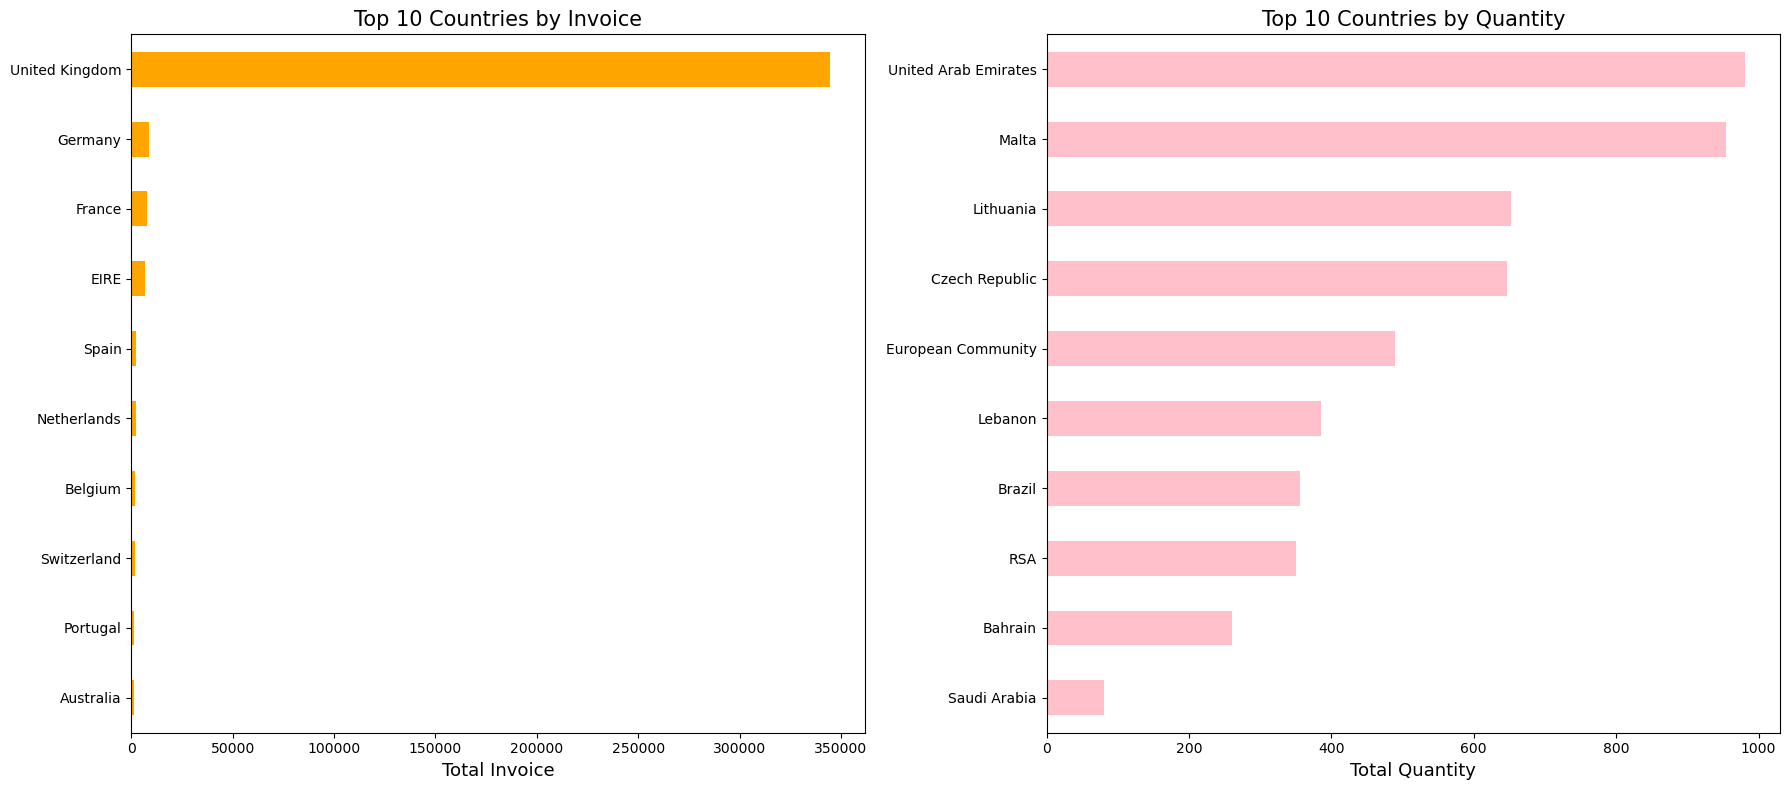

In [38]:
# Show the comparation of top 10 countries by invoice and by quantity
fig,axes=plt.subplots(1,2,figsize=(18,8))

# Visualising the Top 10 populer country by invoice
ax1=cleaned["country"].value_counts().head(10).sort_values(ascending=True).plot(kind='barh',color='orange',ax=axes[0])
axes[0].set_title("Top 10 Countries by Invoice",fontsize=15)
axes[0].set_ylabel('') 
axes[0].set_xlabel("Total Invoice",fontsize=13)


# Visualising the Top 10 populer country by quantity
ax2=cleaned.groupby("country")["quantity"].sum().sort_values(ascending=True).head(10).plot(kind='barh',color='pink',ax=axes[1])
axes[1].set_title("Top 10 Countries by Quantity",size=15)
axes[1].set_ylabel('') 
axes[1].set_xlabel("Total Quantity",fontsize=13)

# Ajust layout to present overlap
plt.tight_layout()
plt.show()

### Findings:

Left Chart (Top Ten Countries by Invoice Quantity):
- The quantity of invoices from the UK is significantly higher than that from other countries, indicating that the UK is a major market.
- Other countries, such as Germany, France, Ireland, etc., have relatively few invoices compared to the UK, showing a clear concentration of the market in the UK.

Right Chart (Top Ten Countries by Sales Quantity):
- The UAE (United Arab Emirates) and Malta have higher sales quantities, ranking as the top two. This suggests that these countries have relatively larger markets in terms of sales quantity.
- Sales quantities for other countries decrease sequentially, but the difference is not as pronounced as in the left chart. This may indicate that sales quantities are more balanced across these countries, with less market concentration.
- Although the UK leads in invoice quantity in the left chart, it does not appear in the top ten of the right chart, suggesting that the UK might have lower sales quantities but higher unit prices.

In [40]:
# 3.1.3 Distribution of Price by Country
countries=cleaned['country'].unique()

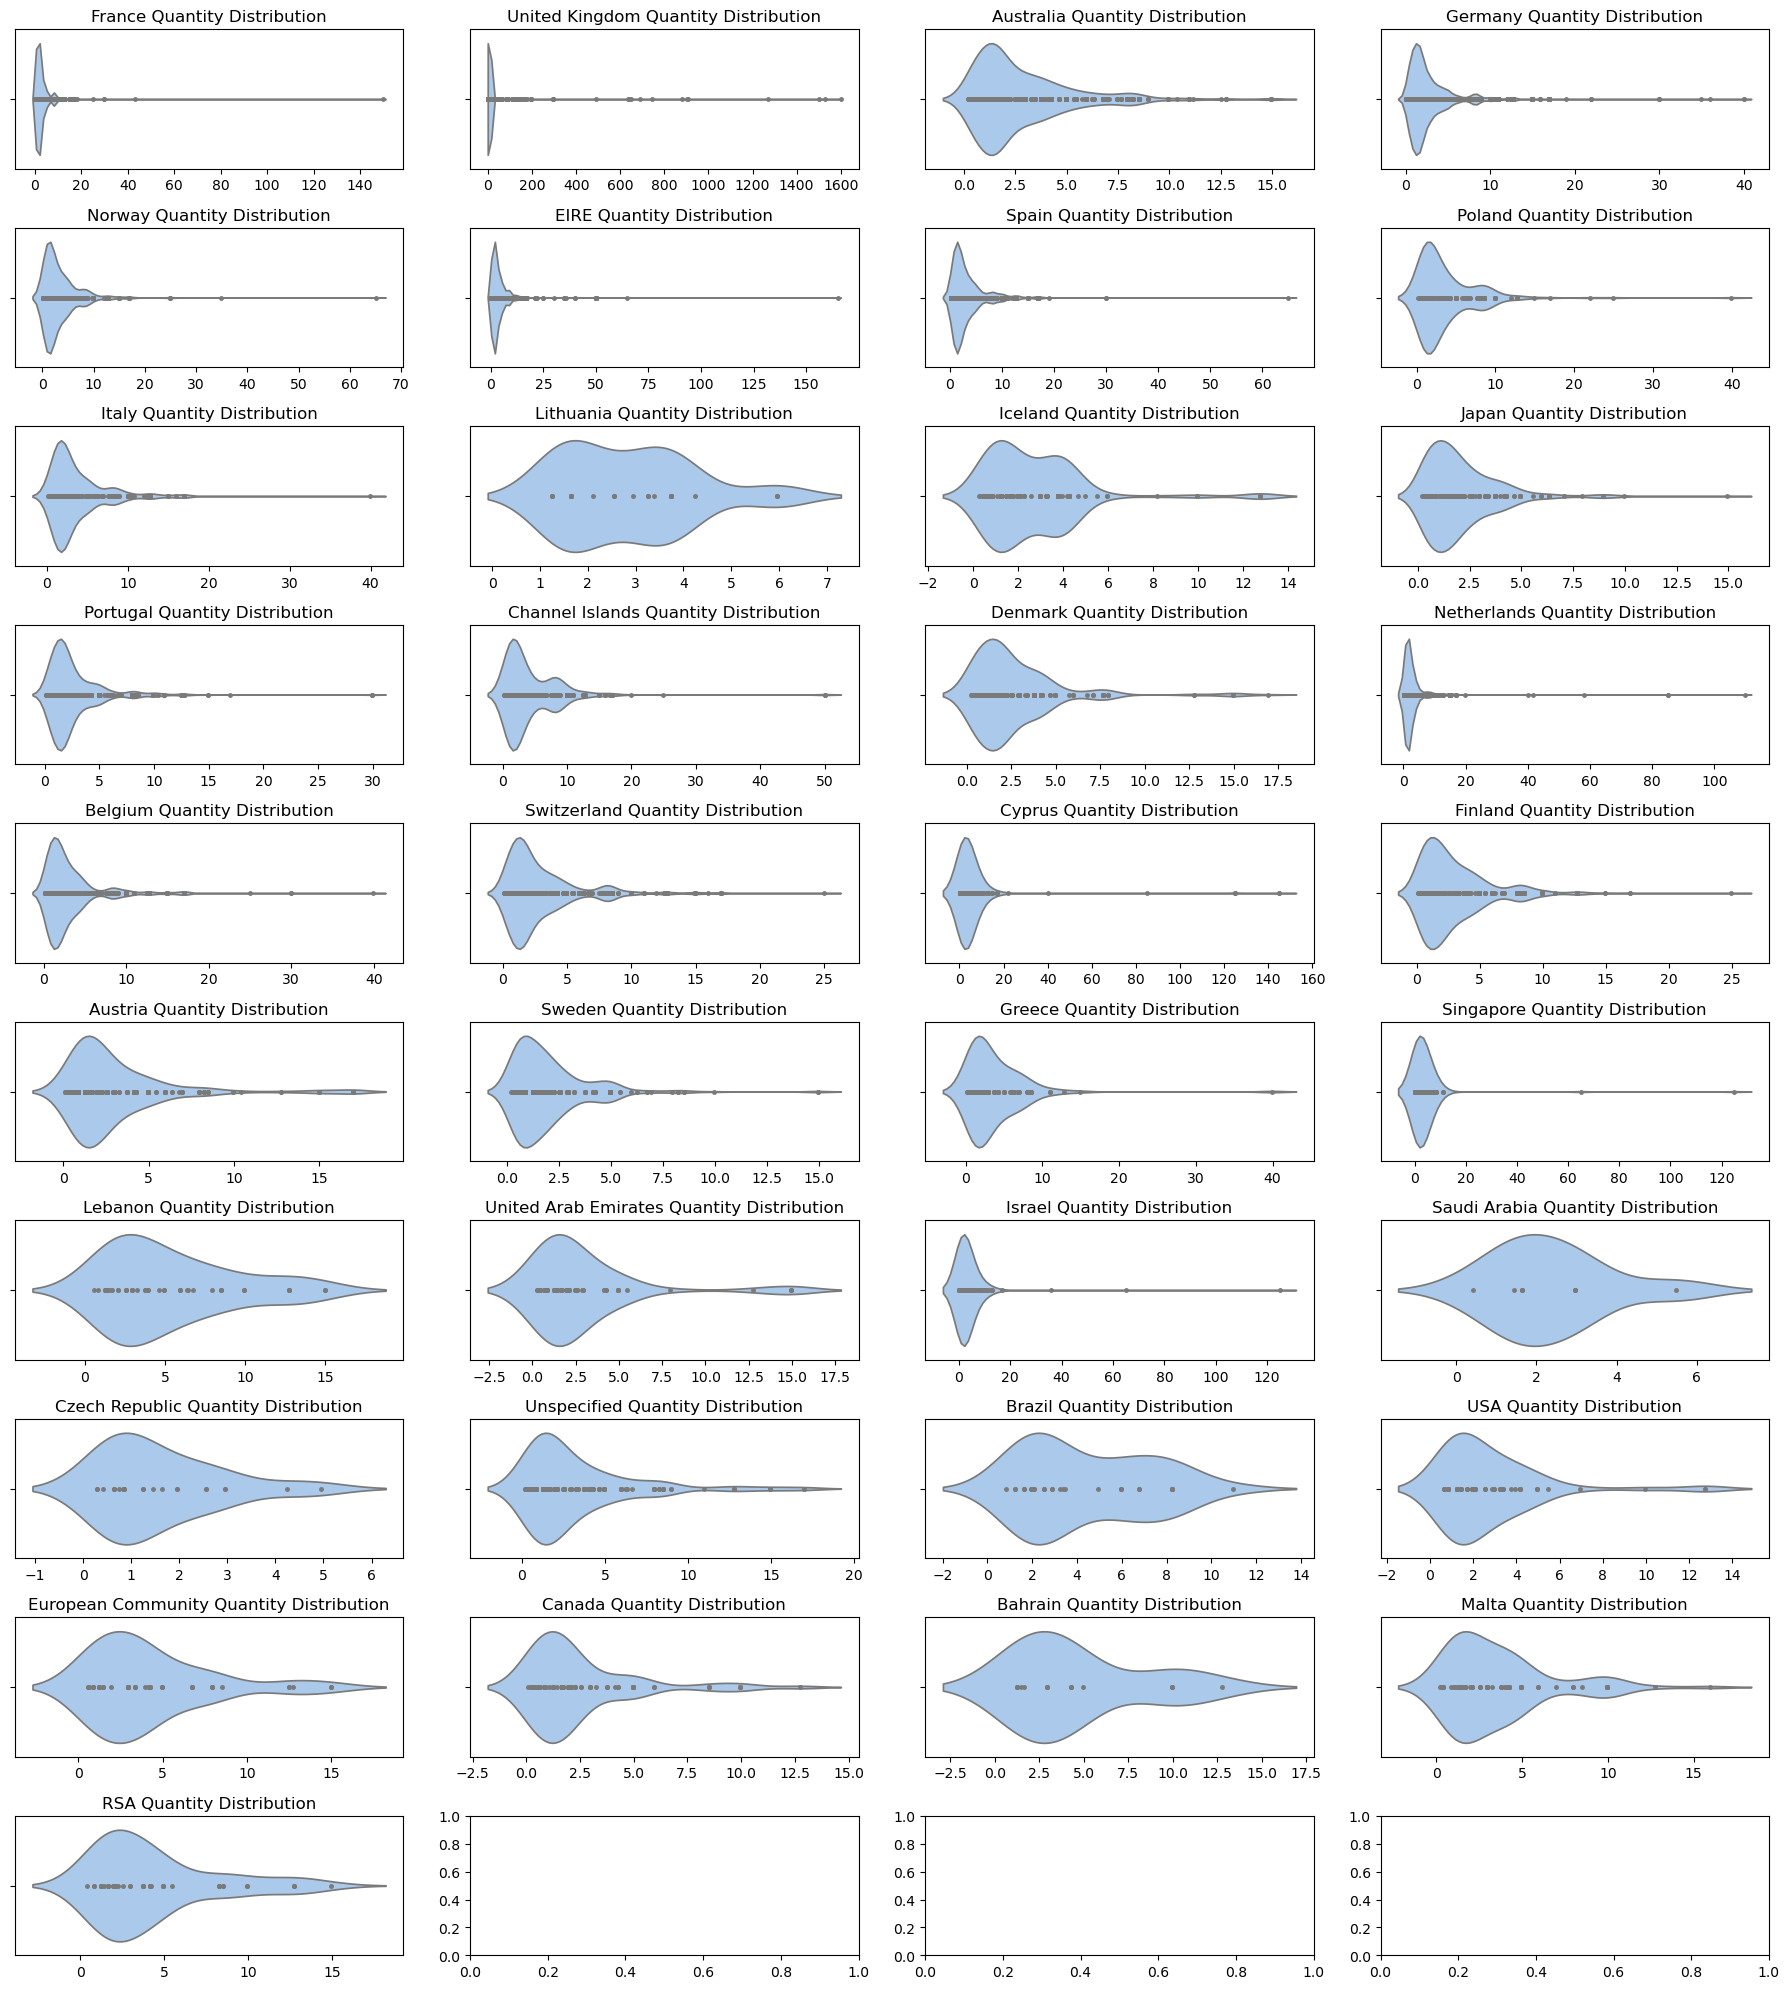

In [41]:
# Explore and visualize the price distribution density for each country
# Create a figure object and subplots
fig,ax=plt.subplots(10,4,figsize=(18,20))
axes_=[axes_row for axes in ax for axes_row in axes]

# Plot the distribution of sales for each country
for i,c in enumerate(countries):
    sns.violinplot(x='price',data=cleaned[cleaned['country']==c],ax=axes_[i],inner='point',palette='pastel')
    axes_[i].set_title(c+' '+'Quantity Distribution')
    axes_[i].set_xlabel('')
    axes_[i].set_ylabel('')

plt.tight_layout()
plt.show()

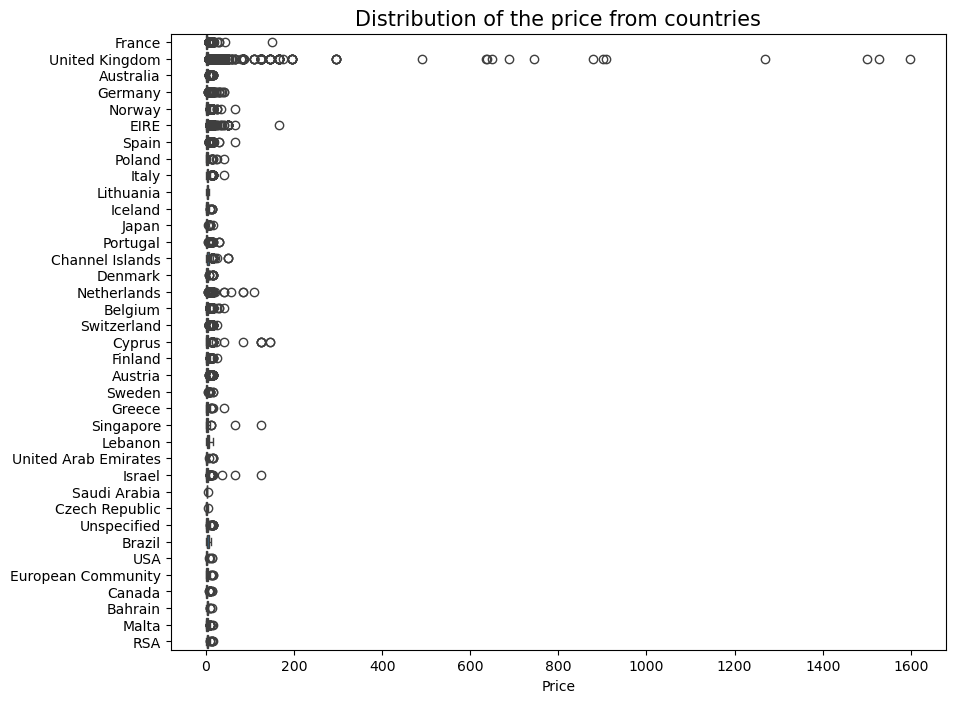

In [42]:
# Visualizing the symmetry and dispersion of price distribution in each country
plt.figure(figsize=(10,8))

sns.boxplot(y='country',x='price',data=cleaned)
plt.title("Distribution of the price from countries",size=15)
plt.xlabel("Price")
plt.ylabel('') 
plt.show()

In [43]:
# Analyze the total price and the average price differences
# Top 10 most popular countries by sum price of order
cleaned.groupby('country')[['price']].sum().sort_values("price",ascending=False).head(10)

,price
country,
United Kingdom,989934.933
EIRE,23175.800
Germany,23014.600
France,20994.330
Spain,7572.460
Belgium,5838.500
Netherlands,5672.380
Switzerland,5146.940
Portugal,3598.040


In [44]:
# Top 10 most popular countries by average price of order
cleaned.groupby('country')['price'].mean().sort_values(ascending=False)

country
Lebanon                 5.387556
Cyprus                  5.189983
Bahrain                 4.644118
Brazil                  4.456250
RSA                     4.352632
European Community      4.242105
Channel Islands         4.148794
Singapore               3.679488
Israel                  3.667714
Greece                  3.649930
Italy                   3.589848
Poland                  3.586211
Malta                   3.554112
EIRE                    3.387780
Norway                  3.290107
Unspecified             3.219710
Spain                   3.171047
Belgium                 3.028268
Austria                 2.984115
Finland                 2.962658
United Kingdom          2.873416
United Arab Emirates    2.871493
Switzerland             2.857823
Lithuania               2.841143
Australia               2.778592
USA                     2.710746
Germany                 2.693026
France                  2.657174
Iceland                 2.644011
Denmark                 2.574808
Po

In [45]:
# Check the statistic summary of the average price per country
cleaned.groupby('country')['price'].mean().sort_values(ascending=False).describe()

count    37.000000
mean      3.217920
std       0.863561
min       1.599130
25%       2.657174
50%       2.984115
75%       3.649930
max       5.387556
Name: price, dtype: float64

### Findings:

- No orders'price up to 200 were made from other countries than the UK --> UK remarks the highest order price, even tough most orders'price range from 0 to 70.
- The average prices per order vary from 5.39 (max) to 1.60 (min), where UK is below the mean (mean 3.21; UK 2.87)
- In terms of average order price, Lebanon ranks highest; however, its actual price distribution is not particularly high, suggesting that a high average price does not necessarily mean all order prices are high.

In [47]:
# 3.1.4 Geographical Distribution of Sales Density by Country
# Extract data
country_plotly=cleaned.groupby('country')[['total_order_value']].sum().reset_index().sort_values('total_order_value',ascending=False)

In [48]:
# Check the result
country_plotly.head()

,country,total_order_value
35,United Kingdom,6756342.413
23,Netherlands,282161.940
10,EIRE,237641.810
14,Germany,203089.880
13,France,181031.390


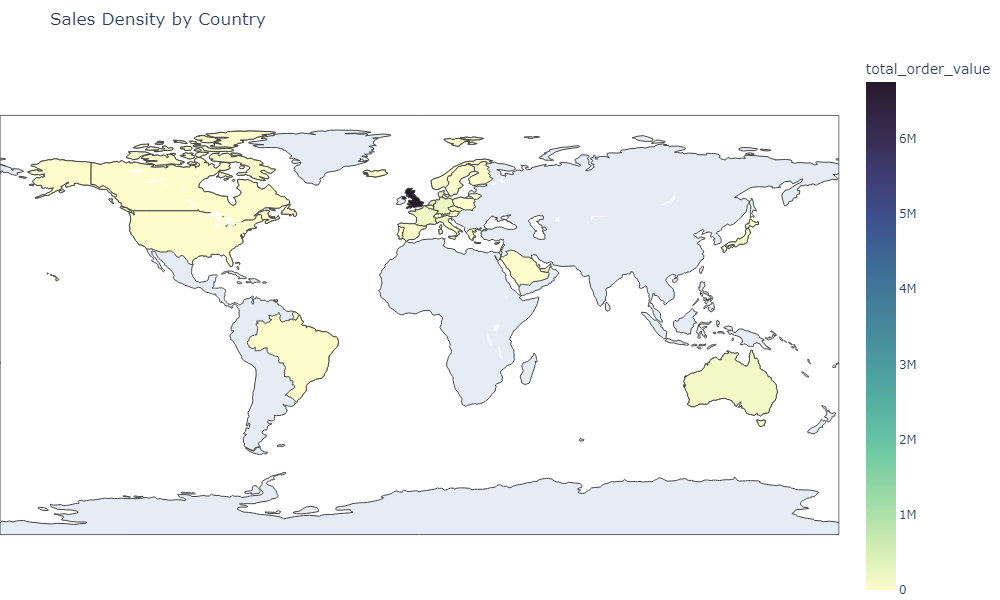

In [49]:
# Create the geographical heatmap
fig = px.choropleth(country_plotly, 
                    locations='country',
                    locationmode='country names',  # Change to 'country names' if using country names
                    color='total_order_value',
                    color_continuous_scale='deep',
                    title='Sales Density by Country')

# Adjust the layout to make the map larger
fig.update_layout(
    autosize=True,
    margin=dict(l=0, r=0, t=50, b=0),  # Adjust margins as needed
    height=600,  # Set height to make the map larger
    width=1000    # Set width to make the map larger
)

# Since GitHub does not support interactive plots, the chart is converted to a static image.
# Display the figure and automatically convert it to a static image
pio.show(fig, renderer='png') # Use the 'png' renderer.

## Summary:
- Invoice Quantity: The UK has the highest invoice quantity, indicating it is the major market, while Germany, France, and Ireland have fewer invoices.
- Sales Quantity: The UAE and Malta lead in sales quantities, suggesting they have larger markets in terms of sales.
- Order Prices: The UK has the highest order price but a lower average price per order compared to the mean. Lebanon has the highest average order price, though actual prices are not very high.

Recommendations:
- Market concentration: It is recommended to pay further attention to the market activities in the UAE and Malta to uncover the reasons behind their high sales volumes, which may provide new growth opportunities.
- Order pricing: The UK market should focus on optimizing the price range and exploring ways to improve profit margins for low-priced orders. The Lebanese market may consider expanding the price range to attract more orders.
- Customer distribution: It is recommended to increase marketing efforts in Germany, France and Ireland to consolidate the customer base in these countries. At the same time, the high average order price in Lebanon should be analyzed in depth in order to develop a more targeted pricing strategy.
- Price data: Price skews in each country, especially high price outliers, should be closely monitored to optimize pricing strategies to balance market supply and demand and profitability.

## 3.2 Time Series Analysis

- The data is from 2010-12-01 to 2011-12-09. So there is only one month in the year 2010.

In [53]:
# 3.2.1 Year
# 3.2.1.1 Distribution of Transactions per Year
# Change the type of invoice_date
cleaned = cleaned.assign(invoice_date=lambda x: pd.to_datetime(x['invoice_date']))

In [54]:
cleaned['invoice_date'].info()

<class 'pandas.core.series.Series'>
Index: 385996 entries, 0 to 400133
Series name: invoice_date
Non-Null Count   Dtype         
--------------   -----         
385996 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 5.9 MB


In [55]:
# Extract the year from invoice date
cleaned['year']=cleaned['invoice_date'].dt.year

In [56]:
# Total quantity per year
quantity_year=cleaned.groupby('year')[['quantity']].sum().reset_index().sort_values(['year'],ascending=False)

In [57]:
# Check the result
quantity_year

,year,quantity
1,2011,4556889
0,2010,304896


In [58]:
# 3.2.1.2 Distribution of Total Customers per Year
# Group by year and customer_id, and calculate the number of unique customer_id for each year
unique_customers_per_year = cleaned.groupby('year')['customer_id'].nunique().reset_index()

In [59]:
# Check the result
unique_customers_per_year

,year,customer_id
0,2010,882
1,2011,4200


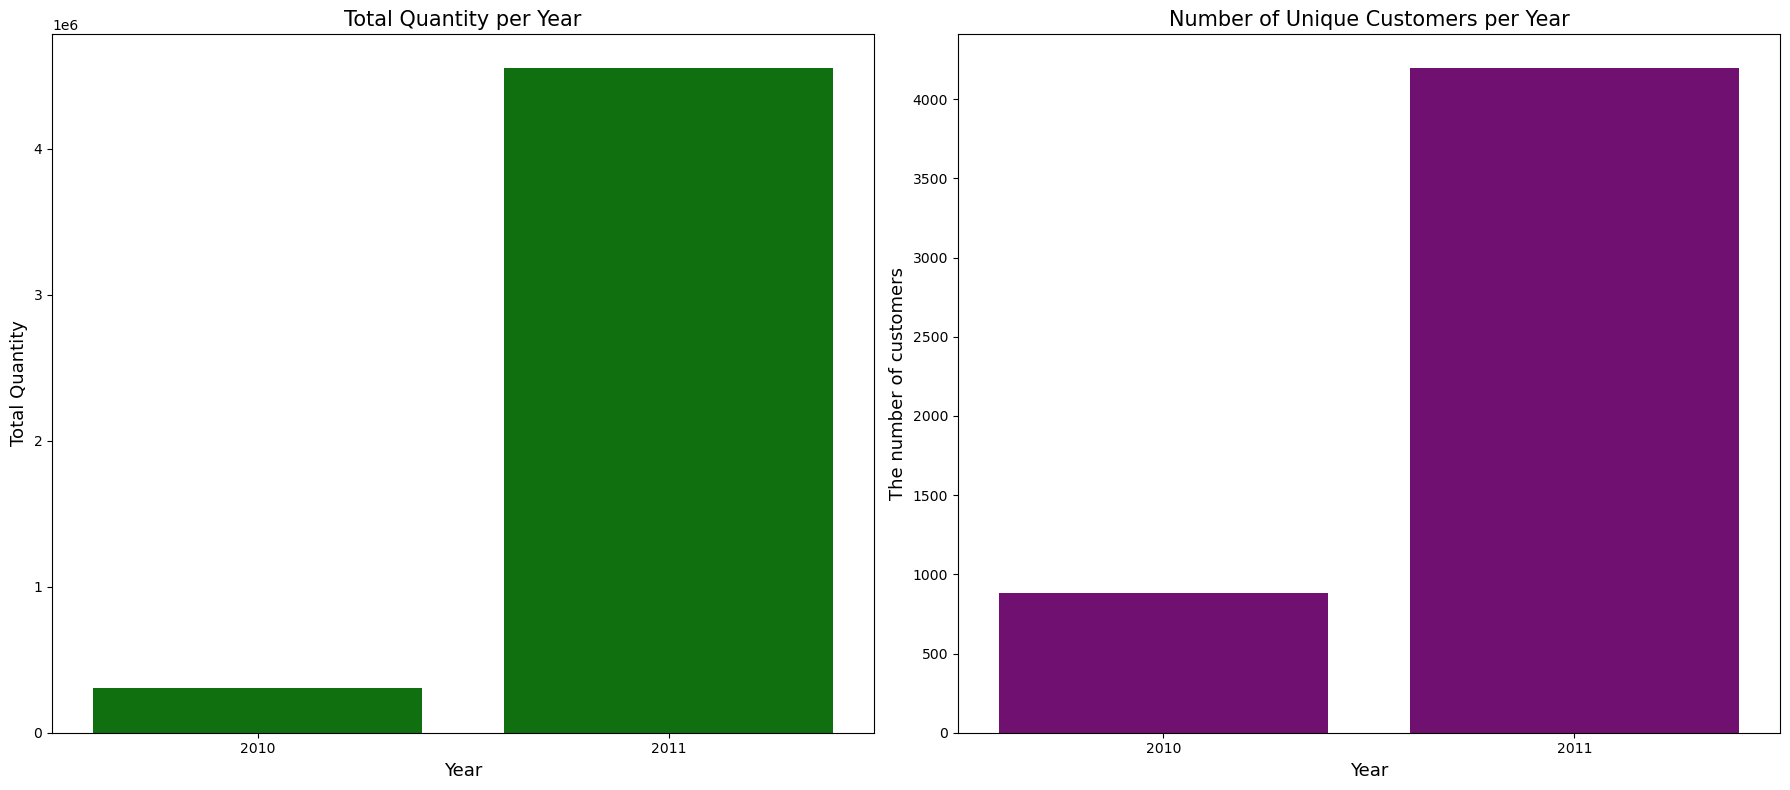

In [60]:
# Show the comparation of the yealy sales data
fig,axes=plt.subplots(1,2,figsize=(18,8))

# Total quantity per year
ax1=sns.barplot(x='year',y='quantity',data=quantity_year,color='green',ax=axes[0])
axes[0].set_title('Total Quantity per Year',fontsize=15)
axes[0].set_xlabel('Year',fontsize=13)
axes[0].set_ylabel('Total Quantity',fontsize=13)

# Show the unique customers per year
ax2=sns.barplot(x='year',y='customer_id',data=unique_customers_per_year,color='purple',ax=axes[1])
axes[1].set_title('Number of Unique Customers per Year',fontsize=15)
axes[1].set_xlabel('Year',fontsize=13)
axes[1].set_ylabel('The number of customers',fontsize=13)

plt.tight_layout()
plt.show()

### Findings:

Low Sales Volume but High Customer Count in 2010:
- In 2010, the sales volume accounted for only 6.2% of the total, but the customer count made up 17%. 
- This indicates that in 2010, customers had a lower purchase frequency or each customer made smaller purchases.

Sales and Customer Growth from 2010 to 2011:
- From 2010 to 2011, the sales volume saw significant growth, and the customer count also increased. However, the growth rate of customers was lower than that of sales volume. 
- This suggests that in 2011, the purchase frequency or the amount purchased by customers increased significantly.

These data points might reflect improvements in sales strategy, customer retention, or new customer acquisition in 2011, leading to a substantial increase in sales volume.

In [62]:
# 3.2.2 Month
# 3.2.2.1 Distribution of Transactions per Month

I separated the data from December 2010 and 2011 to avoid the inaccuracies in analysis caused by the cumulative sales when calculating repeated months.

In [64]:
# Extract month from invoice date
cleaned['month']=cleaned['invoice_date'].dt.month

In [65]:
# Check the result
cleaned.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,year,month
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France,30.00,VINTAGE HEADS AND TAILS CARD GAME,2010,12
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.30,WOODEN FRAME ANTIQUE WHITE,2010,12
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.50,JUMBO BAG PINK VINTAGE PAISLEY,2010,12
3,536381,37444A,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom,2.95,YELLOW BREAKFAST CUP AND SAUCER,2010,12
4,536381,15056BL,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom,11.90,EDWARDIAN PARASOL BLACK,2010,12


In [66]:
# Group by month in 2011 and calculate the total transactions
data_2011=cleaned[cleaned['year']==2011]

In [67]:
# Calculate the total quantity per month
quantity_by_month_2011=data_2011.groupby('month')[['quantity']].sum()

In [68]:
# Reset the index to convert month from an index to a column
quantity_by_month_2011=quantity_by_month_2011.sort_values(['quantity'],ascending=False).reset_index()

In [69]:
# Check the result
quantity_by_month_2011

,month,quantity
0,11,647645
1,10,558213
2,9,536032
3,8,389244
4,5,366561
5,7,359967
6,6,353410
7,3,340292
8,4,280127
9,2,262094


In [70]:
# Choose the data from 2010
data_2010=cleaned[cleaned['year']==2010]

In [71]:
#  Group by month in 2010 and calculate the total sum of total_order_value
quantity_by_month_2010=data_2010.groupby('month')[['quantity']].sum()

In [72]:
# Reset the index
quantity_by_month_2010=quantity_by_month_2010.reset_index()

In [73]:
# Check the result
quantity_by_month_2010

,month,quantity
0,12,304896


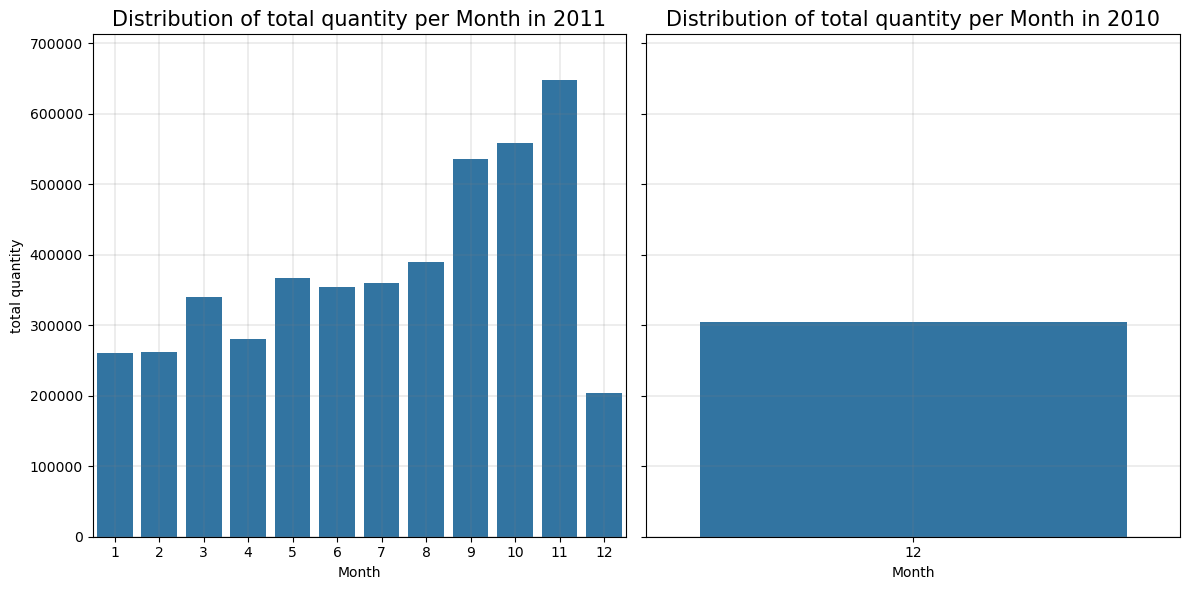

In [74]:
# Create the canvas and subplots, ensuring each subplot is of the same size
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6),sharey=True)

# First subplot: Distribution of invoices per month in 2011.
sns.barplot(x='month',y='quantity',data=quantity_by_month_2011,ax=ax1)
ax1.set_title("Distribution of total quantity per Month in 2011",size=15)
ax1.set_xlabel("Month")
ax1.set_ylabel("total quantity")
ax1.grid(color='gray',linestyle='-',linewidth=0.2)

# Set the Y-axis range for the first subplot
ax1.set_ylim(0, max(quantity_by_month_2011['quantity']) * 1.1)

# Second subplot: Distribution of invoices per month in 2010
sns.barplot(x='month',y='quantity',data=quantity_by_month_2010,ax=ax2)
ax2.set_title("Distribution of total quantity per Month in 2010",size=15)
ax2.set_xlabel("Month")
ax2.set_ylabel("total quantity")
ax2.grid(color='gray',linestyle='-',linewidth=0.2)

# Set the Y-axis range for the second subplot, using the maximum value from the first subplot as a reference
ax2.set_ylim(0, max(quantity_by_month_2011['quantity']) * 1.1)

# Adjust the layout of the subplots
plt.tight_layout()

In [75]:
print(f'The highest number of transactions is the month:',quantity_by_month_2011.iloc[0,0])

The highest number of transactions is the month: 11


In [76]:
# Check the result with aggregate total quantity in December
monthly_quantity=cleaned.groupby(['month'])['quantity'].sum().reset_index()

In [77]:
# Check the result
monthly_quantity

,month,quantity
0,1,260031
1,2,262094
2,3,340292
3,4,280127
4,5,366561
5,6,353410
6,7,359967
7,8,389244
8,9,536032
9,10,558213


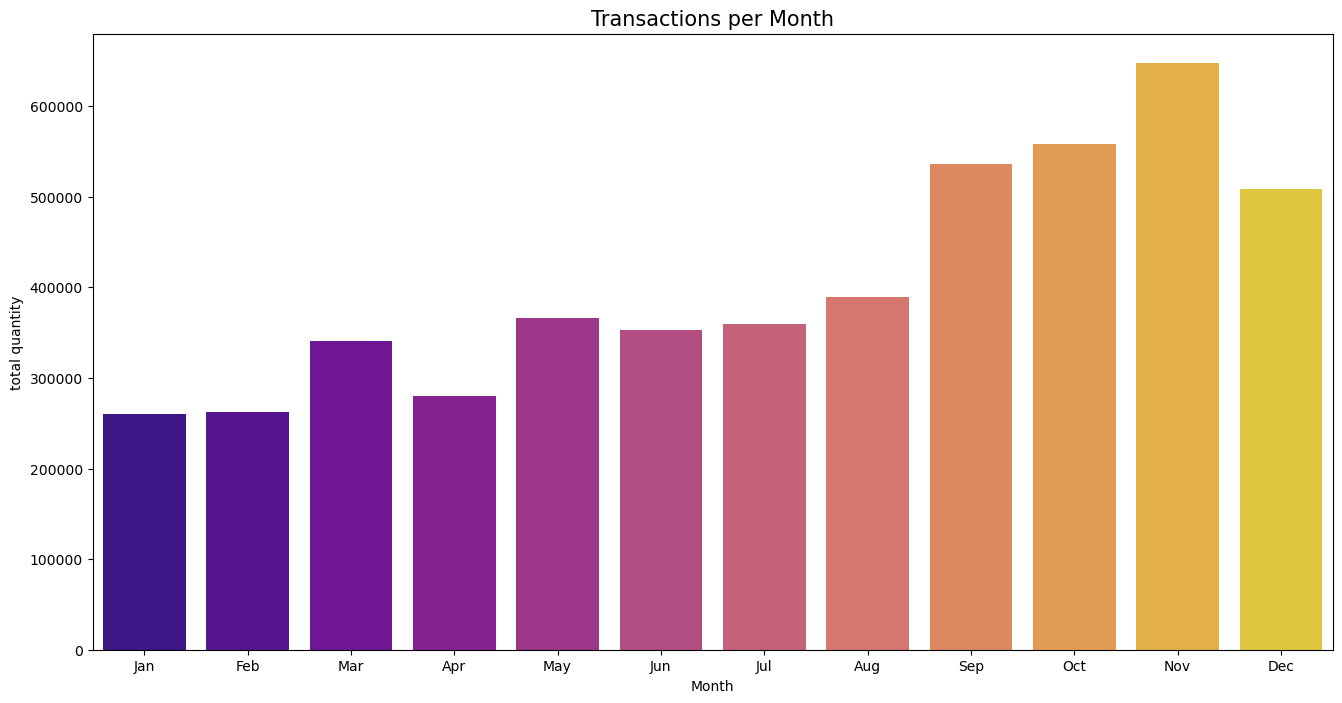

In [78]:
# Check the plot without seperate december
plt.figure(figsize=(16,8))

sns.barplot(x='month',y='quantity',data=monthly_quantity,palette='plasma',ax=plt.gca())

plt.title("Transactions per Month",fontsize=15)
plt.xlabel("Month")
plt.ylabel("total quantity")

plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11],labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],rotation=0)

plt.show()

#### Findings:
- Separately calculating December 2010 and December 2011 can lead to data bias, which may give the false impression that December 2011 had poor sales performance.
- Merging the data for December 2010 and December 2011 will help to more clearly display the overall sales trend for December.

In [80]:
# 3.2.2.2 Distribution of Customers per Month
# Aggregate the month wich customer id
unique_customers_per_month =cleaned.groupby('month')[['customer_id']].nunique().reset_index()

In [81]:
# Check the result
unique_customers_per_month

,month,customer_id
0,1,733
1,2,753
2,3,968
3,4,846
4,5,1050
5,6,982
6,7,942
7,8,930
8,9,1250
9,10,1353


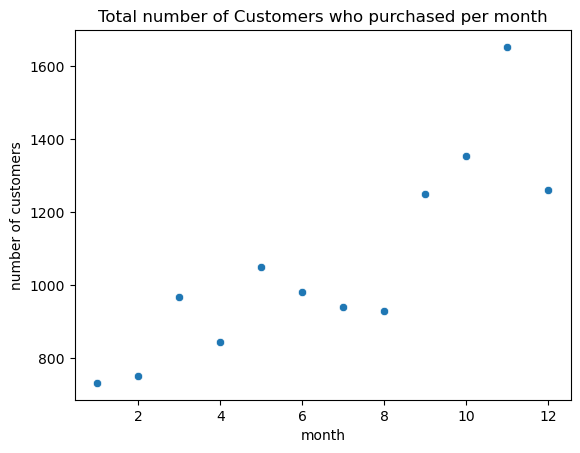

In [82]:
# plot the distribution of customers per month
sns.scatterplot(x='month',y='customer_id',data=unique_customers_per_month)
plt.title('Total number of Customers who purchased per month')
plt.xlabel('month')
plt.ylabel('number of customers')
plt.show()

In [83]:
# 3.2.2.3 Distribution of Invoices per Month
invoice_per_month=cleaned.groupby('month')[['invoice']].nunique().reset_index()

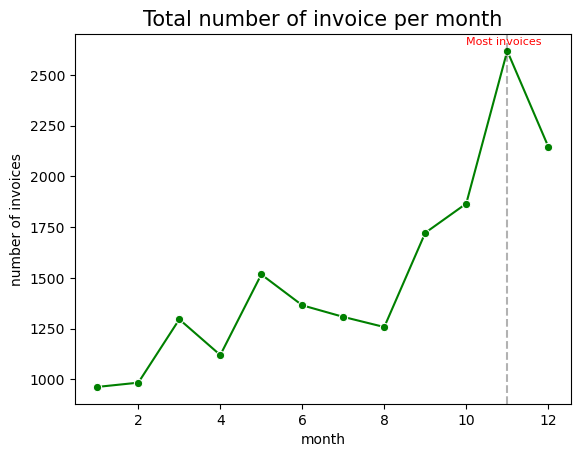

In [84]:
# Distribution number of invoice per month
sns.lineplot(x='month',y='invoice',data=invoice_per_month,marker='o',color='green')

plt.title('Total number of invoice per month',fontsize=15)
plt.xlabel('month')
plt.ylabel('number of invoices')
plt.axvline(11, color = "k", linestyle = '--', alpha = 0.3)

# Adjust the text position and ensure it is within the chart range
plt.text(10, 2650, "Most invoices", size=8, color='red')

plt.show()

In [85]:
# 3.2.3 Week
# 3.2.3.1  Distribution of Transactions by Weekday
# Create a dictionary that maps numbers to the abbreviations of weekdays
weekday_map = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'
}

In [86]:
# Map the dictionary
cleaned['weekday']=cleaned['invoice_date'].dt.weekday.map(weekday_map)

In [87]:
# Quantity per weekday
weekday_counts = cleaned.groupby('weekday')['quantity'].sum()

In [88]:
# Create a list containing all the days of the week
all_weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [89]:
# If there is no data for a particular day, fill it with 0
counts = [weekday_counts.get(day, 0) for day in all_weekdays]

Text(0, 0.5, 'Count')

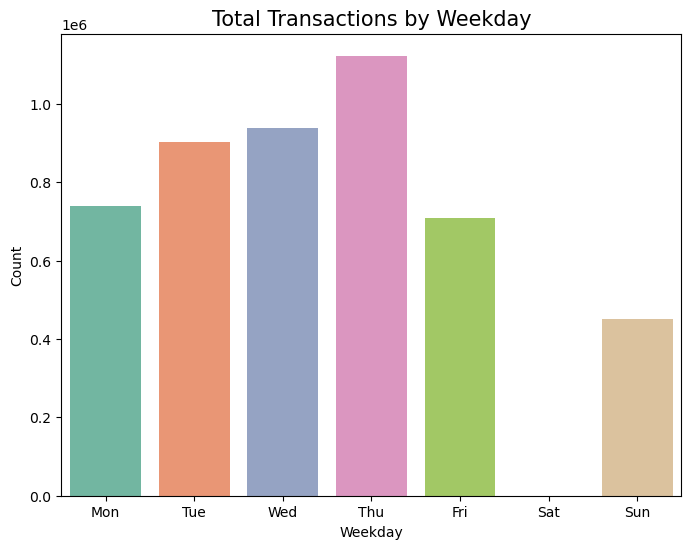

In [90]:
# Distribution of transactions per weekday
plt.figure(figsize=(8, 6))
sns.barplot(x=all_weekdays, y=counts,palette='Set2')
plt.title('Total Transactions by Weekday',size=15)
plt.xlabel('Weekday')
plt.ylabel('Count')

In [91]:
# 3.2.4 Day
# 3.2.4.1 Distribution of Transactions per Day
# Extract day from invoice date
cleaned['day']=cleaned['invoice_date'].dt.day

In [92]:
cleaned.head(3)

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,year,month,weekday,day
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France,30.0,VINTAGE HEADS AND TAILS CARD GAME,2010,12,Wed,1
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.3,WOODEN FRAME ANTIQUE WHITE,2010,12,Wed,1
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.5,JUMBO BAG PINK VINTAGE PAISLEY,2010,12,Wed,1


In [93]:
# Quantity per weekday
day_quantity = cleaned.groupby('day')[['quantity']].sum().reset_index()

In [94]:
day_quantity

,day,quantity
0,1,166948
1,2,149227
2,3,143389
3,4,186533
4,5,211612
5,6,192029
6,7,195332
7,8,170948
8,9,162605
9,10,159751


Text(0, 0.5, 'Quantity')

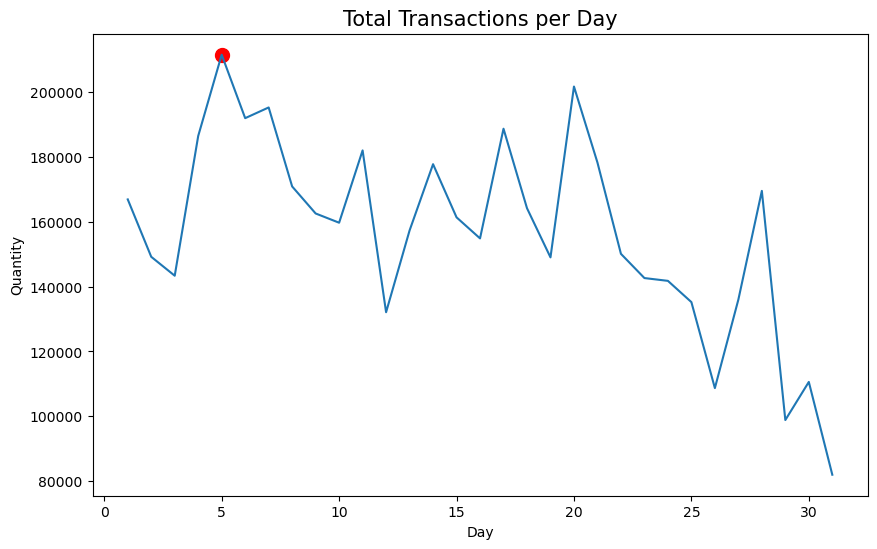

In [95]:
# Mark the hightes purchased day 
plt.figure(figsize=(10,6))
sns.lineplot(x='day',y='quantity',data=day_quantity)

# Find the highest point
max_quantity = day_quantity['quantity'].max()
max_day = day_quantity[day_quantity['quantity'] == max_quantity]['day'].values[0]

# Color the highest point
plt.scatter(max_day, max_quantity, color='red', s=100)  

# Add titel and labels
plt.title('Total Transactions per Day',size=15)
plt.xlabel('Day')
plt.ylabel('Quantity')

### Summary:

Months:

- Sales gradually increased at the beginning of the year, peaked in November, and slightly declined in December.
- Most of customers purchased also at the last several month of the year,speicially in November.
- The first 8 months of the year were significantly less frequented in orders --> this can be explained by the fact that the Christmas and therefore shopping season starts at the end of the year for most of the customers (Europe).

Weekdays:

- Most transactions were made on thursdays --> from Monday to Thursday, sales increase steadily; from Thursday they fall sharply.
- No transactions are recorded on Saturdays (Why?).
- In general, the first half of the week is significantly stronger in terms of sales.

Days:

- Increase in Sales at the Beginning of the Month: sales show an upward trend in the first few days, reaching a peak around the 5th day. This may indicate that promotional activities, payday, or other factors at the beginning of the month could have driven the increase in sales volume.

- Decline in Sales in the Middle and End of the Month: sales overall show a declining trend, particularly on certain days in the middle and end of the month. This may reflect a decrease in consumer purchasing power in the middle of the month, or that the demand was already met earlier in the month.

# 3.2.5 Season
# 3.2.5.1 Distribution of Transactions by Season

In [98]:
# Difine a function to classify the season
def season(df,column):
     df.loc[df[column].isin([12, 1, 2]), 'season'] = 'winter'
     df.loc[df[column].isin([3, 4, 5]), 'season'] = 'spring'
     df.loc[df[column].isin([6, 7, 8]), 'season'] = 'summer'
     df.loc[df[column].isin([9, 10, 11]), 'season'] = 'autumn'
   
     return df

In [99]:
# Call the season function
data=season(cleaned, 'month')

In [100]:
# Check the result
data.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,year,month,weekday,day,season
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France,30.00,VINTAGE HEADS AND TAILS CARD GAME,2010,12,Wed,1,winter
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.30,WOODEN FRAME ANTIQUE WHITE,2010,12,Wed,1,winter
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.50,JUMBO BAG PINK VINTAGE PAISLEY,2010,12,Wed,1,winter
3,536381,37444A,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom,2.95,YELLOW BREAKFAST CUP AND SAUCER,2010,12,Wed,1,winter
4,536381,15056BL,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom,11.90,EDWARDIAN PARASOL BLACK,2010,12,Wed,1,winter


In [101]:
# Seasons with tatal_quantity
season_quantity=data.groupby('season')[['quantity']].sum().reset_index().sort_values(by='quantity', ascending=False)

In [102]:
# Check the result
season_quantity.head()

,season,quantity
0,autumn,1741890
2,summer,1102621
3,winter,1030294
1,spring,986980


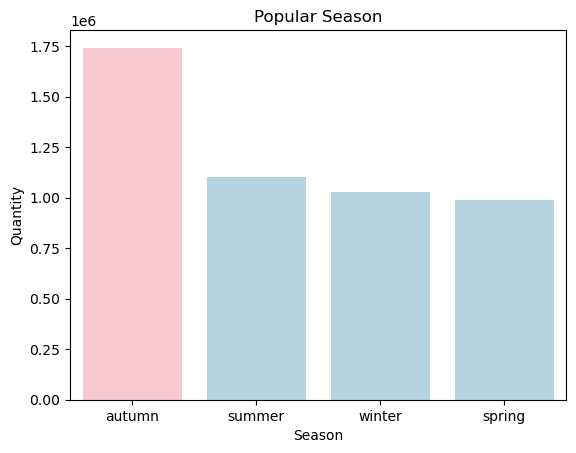

In [103]:
# Show the popular season
colors = ['pink' if season == 'autumn' else 'lightblue' for season in season_quantity['season']]

sns.barplot(x='season',y='quantity',data=season_quantity,palette=colors)
plt.title('Popular Season')
plt.xlabel('Season')
plt.ylabel('Quantity')
plt.show()

### Findings:

Autumn Might Be the Peak Sales Season:

- Sales in autumn are significantly higher than in other seasons, which may indicate that autumn is the peak sales season. Possible reasons include increased seasonal demand (such as christmas shopping, autumn promotions, etc.) or that certain products sell particularly well in autumn.

Summer Sales Slightly Higher Than Winter and Spring:

- Although the sales in summer, winter, and spring do not differ greatly, summer sales are slightly higher than those in winter and spring. This could indicate that specific summer demands, such as travel or outdoor activities, have driven the increase in sales.

Winter and Spring Sales:

- The sales in winter and spring are quite close, which may suggest that consumer behavior patterns are similar in these two seasons, or that the promotional efforts and market activities during these seasons are relatively comparable.

In [105]:
# 3.2.5.2 Top 3 products by sales for each season
# Extract products and sales by season
season_stockcode=data.groupby(['season','stock_code'])[['quantity']].sum().reset_index().sort_values(by=['season','quantity'], ascending=False)

In [106]:
season_stockcode.head()

,season,stock_code,quantity
9591,winter,22197,11661
11184,winter,84077,11447
11558,winter,85123A,9174
8941,winter,21212,9070
11544,winter,85099B,7976


In [107]:
# Filter specific stock codes within each season
autumn_stockcode = season_stockcode[season_stockcode['season'] == 'autumn'].head(3)
spring_stockcode = season_stockcode[season_stockcode['season'] == 'spring'].head(3)
summer_stockcode = season_stockcode[season_stockcode['season'] == 'summer'].head(3)
winter_stockcode = season_stockcode[season_stockcode['season'] == 'winter'].head(3)

In [108]:
# Check one of season with the top 3 stock_code 
autumn_stockcode

,season,stock_code,quantity
1688,autumn,23084,18673
906,autumn,22197,17659
2453,autumn,84077,16040


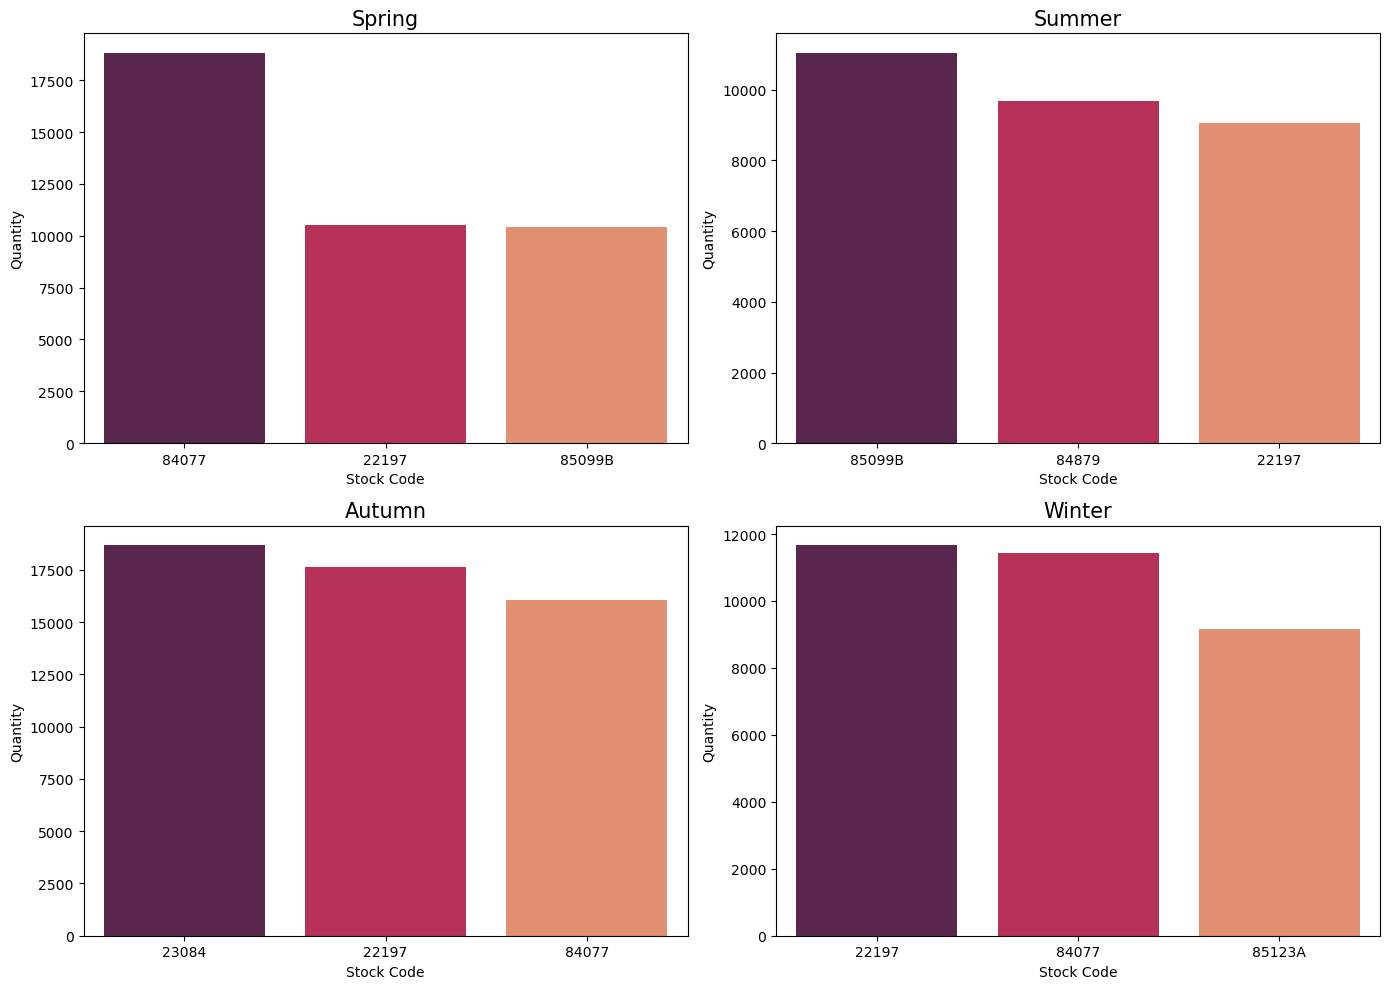

In [109]:
# Show the popular stock code in each season
plt.figure(figsize=(14, 10))

# Barchart of spring
plt.subplot(2, 2, 1)
sns.barplot(x='stock_code', y='quantity', data=spring_stockcode, palette='rocket')
plt.title('Spring',size=15)
plt.xlabel('Stock Code')
plt.ylabel('Quantity')

# Barchart of Summer
plt.subplot(2, 2, 2)
sns.barplot(x='stock_code', y='quantity', data=summer_stockcode, palette='rocket')
plt.title('Summer',size=15)
plt.xlabel('Stock Code')
plt.ylabel('Quantity')

# Barchart of Autumn
plt.subplot(2, 2, 3)
sns.barplot(x='stock_code', y='quantity', data=autumn_stockcode, palette='rocket')
plt.title('Autumn',size=15)
plt.xlabel('Stock Code')
plt.ylabel('Quantity')

# Barchart of Winter
plt.subplot(2, 2, 4)
sns.barplot(x='stock_code', y='quantity', data=winter_stockcode, palette='rocket')
plt.title('Winter',size=15)
plt.xlabel('Stock Code')
plt.ylabel('Quantity')

# Adjust the layout of the subplots
plt.tight_layout()

# Display the plot
plt.show()

In [110]:
# The specified list of stock codes
stockcode_list=['84077','22197','85099B','84879','22197','23084','85123A']

In [111]:
# Filter records where stock_code is in the specified list
description=cleaned[cleaned['stock_code'].isin(stockcode_list)]

In [112]:
# Select only the stock_code and description columns and remove duplicates
description[['stock_code','description']].drop_duplicates()

,stock_code,description
319,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
1500,85123A,CREAM HANGING HEART T-LIGHT HOLDER
1533,22197,POPCORN HOLDER
1562,84879,ASSORTED COLOUR BIRD ORNAMENT
2856,85099B,JUMBO BAG RED RETROSPOT
47126,23084,RABBIT NIGHT LIGHT


### Findings：
- Popcorn containers are bestsellers in every season, followed by WWII gliders.
- These popular products cover various areas such as historical themes, home decor, entertainment, gardening, practical storage, and household lighting. Their sales performance may be driven by specific seasons, holidays, and the particular needs of consumers.

In [114]:
# 3.2.5.3 Total orders and total sales by season
# Aggregate season with total orders and total sales 
season_segment = cleaned.groupby('season').agg(
    num_orders=('invoice', 'nunique'),
    total_order_value=('total_order_value', 'sum')).reset_index()

In [115]:
# Define the season order
season_order=['spring', 'summer', 'autumn', 'winter']

In [116]:
# Set the season column as a categorical type with the specified order
season_segment['season']=pd.Categorical(season_segment['season'],categories=season_order,ordered=True)

In [117]:
# Check the result
season_segment=season_segment.sort_values('season').reset_index(drop=True)

In [118]:
season_segment

,season,num_orders,total_order_value
0,spring,3933,1640916.261
1,summer,3931,1798108.181
2,autumn,6206,2991331.381
3,winter,4094,1782948.440


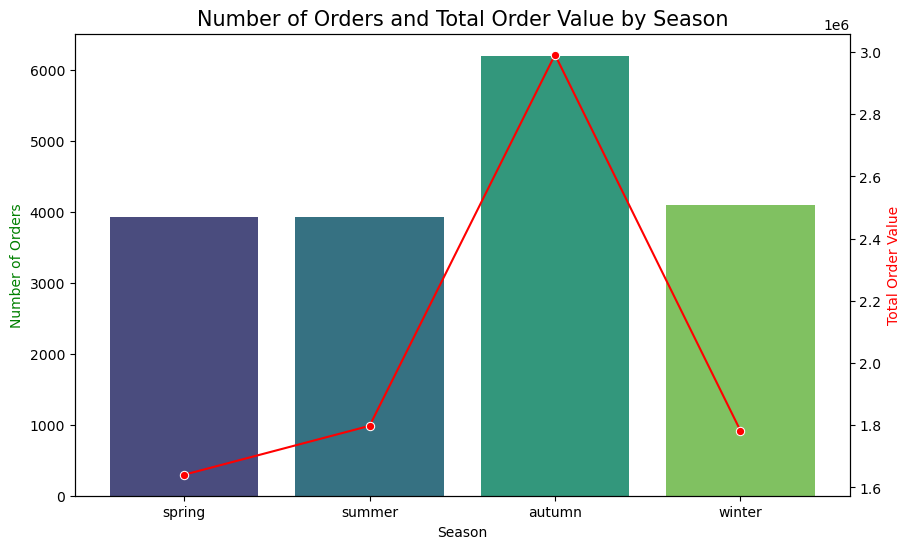

In [119]:
# Create Dual-Axis Chart
fig, ax1=plt.subplots(figsize=(10,6))

# Create a second y-axis that shares the same x-axis
ax2=ax1.twinx()

# Plot the number of orders with a bar plot on the first y-axis
sns.barplot(x='season',y='num_orders',data=season_segment,palette='viridis',ax=ax1)

# Plot the total order value with a line plot on the second y-axis
sns.lineplot(x='season',y='total_order_value',data=season_segment,sort=False,color='red',marker='o',ax=ax2)

# Set the title and the labels of the plot
ax1.set_title('Number of Orders and Total Order Value by Season',fontsize=15)
ax1.set_xlabel('Season')
ax1.set_ylabel('Number of Orders',color='green')
ax2.set_ylabel('Total Order Value',color='red')

# Display the plot
plt.show()

### Summary:
- Seasonal Sales Variations: Products show significant sales changes across seasons. For instance, product 84077 peaks in spring and autumn but drops in summer and winter.
- Autumn Peak: Highest orders and sales occur in autumn, likely due to seasonal promotions and events.
- Winter Decline: Overall sales decrease in winter, though some products still perform well.
- Product Performance: Products like 22197 excel in spring and winter but underperform in summer and autumn.

Recommendations:
- Tailor Marketing Strategies: Boost promotions in peak seasons like autumn and introduce winter-specific products or discounts to address seasonal declines.

# 4 Cohort Analysis

## 4.1 Define Cohorts

In [123]:
# Define a function that will parse the date
def get_day(x):
    return datetime(x.year, x.month, x.day)

In [124]:
# Create InvoiceDay column
cleaned = cleaned.assign(InvoiceDay=lambda x: x['invoice_date'].apply(get_day))

In [125]:
# Group by customer_id and select the InvoiceDay value
grouping=cleaned.groupby('customer_id')['InvoiceDay']

In [126]:
# Assign a minimum InvoiceDay value to the dataset
cleaned['CohortDay']=grouping.transform('min')

In [127]:
cleaned.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,year,month,weekday,day,season,InvoiceDay,CohortDay
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France,30.00,VINTAGE HEADS AND TAILS CARD GAME,2010,12,Wed,1,winter,2010-12-01,2010-12-01
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.30,WOODEN FRAME ANTIQUE WHITE,2010,12,Wed,1,winter,2010-12-01,2010-12-01
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.50,JUMBO BAG PINK VINTAGE PAISLEY,2010,12,Wed,1,winter,2010-12-01,2010-12-01
3,536381,37444A,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom,2.95,YELLOW BREAKFAST CUP AND SAUCER,2010,12,Wed,1,winter,2010-12-01,2010-12-01
4,536381,15056BL,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom,11.90,EDWARDIAN PARASOL BLACK,2010,12,Wed,1,winter,2010-12-01,2010-12-01


## 4.2 Data Collection and Preparation

In [129]:
# Define a function to get date
def get_date_int(df,column):
    year=df[column].dt.year
    month=df[column].dt.month
    day=df[column].dt.day
    return year,month,day

In [130]:
# Get the integers for date parts from the 'InvoiceDay' column
invoice_year,invoice_month,invoice_day=get_date_int(cleaned,'InvoiceDay')

In [131]:
# Get the integers for date parts from the 'CohortDay' column
cohort_year,cohort_month,cohort_day=get_date_int(cleaned,'CohortDay')

## 4.3 Calculate Cohort Metrics

In [133]:
# Calculate difference in years
years_diff=invoice_year-cohort_year

In [134]:
# Calculate difference in months
months_diff=invoice_month-cohort_month

In [135]:
# Calculate difference in days
days_diff=invoice_day-cohort_day

In [136]:
# Extract the difference in days from all previous values
cleaned['CohortIndex']=years_diff*12+months_diff+1

In [137]:
cleaned.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,year,month,weekday,day,season,InvoiceDay,CohortDay,CohortIndex
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France,30.00,VINTAGE HEADS AND TAILS CARD GAME,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.30,WOODEN FRAME ANTIQUE WHITE,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.50,JUMBO BAG PINK VINTAGE PAISLEY,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1
3,536381,37444A,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom,2.95,YELLOW BREAKFAST CUP AND SAUCER,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1
4,536381,15056BL,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom,11.90,EDWARDIAN PARASOL BLACK,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1


In [138]:
# Create 'CohortMonth' column
cleaned['CohortMonth'] = cleaned['CohortDay'].dt.to_period('M')

In [139]:
cleaned.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,year,month,weekday,day,season,InvoiceDay,CohortDay,CohortIndex,CohortMonth
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France,30.00,VINTAGE HEADS AND TAILS CARD GAME,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1,2010-12
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.30,WOODEN FRAME ANTIQUE WHITE,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1,2010-12
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.50,JUMBO BAG PINK VINTAGE PAISLEY,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1,2010-12
3,536381,37444A,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom,2.95,YELLOW BREAKFAST CUP AND SAUCER,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1,2010-12
4,536381,15056BL,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom,11.90,EDWARDIAN PARASOL BLACK,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1,2010-12


In [140]:
# Create a groupby object as grouping DataFrame 
grouping=cleaned.groupby(['CohortMonth','CohortIndex'])

In [141]:
# Count the number of uniqe values per customer_id
cohort_data=grouping['customer_id'].apply(pd.Series.nunique).reset_index()

## 4.4 Analyze and Visualize

In [143]:
# Creat a pivot
cohort_counts=cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='customer_id')

In [144]:
# Show the pivot
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,882.0,320.0,284.0,336.0,315.0,350.0,317.0,305.0,311.0,346.0,329.0,441.0,232.0
2011-01,413.0,88.0,111.0,96.0,133.0,118.0,104.0,99.0,123.0,135.0,152.0,49.0,NaN
2011-02,381.0,71.0,71.0,108.0,103.0,92.0,97.0,102.0,93.0,115.0,26.0,NaN,NaN
2011-03,450.0,65.0,112.0,87.0,101.0,75.0,118.0,104.0,125.0,40.0,NaN,NaN,NaN
2011-04,299.0,63.0,61.0,63.0,59.0,68.0,63.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,55.0,49.0,49.0,60.0,65.0,75.0,26.0,NaN,NaN,NaN,NaN,NaN
2011-06,241.0,42.0,38.0,64.0,56.0,78.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,186.0,32.0,38.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,170.0,34.0,41.0,42.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
# Select the first column and store it to cohort_sizes
cohort_sizes=cohort_counts.iloc[:,0]

In [146]:
# Divide the cohort count by cohort sizes along the rows
retention=cohort_counts.divide(cohort_sizes,axis=0)*100

In [147]:
# Show the retention
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,100.0,36.281179,32.199546,38.095238,35.714286,39.682540,35.941043,34.580499,35.260771,39.229025,37.301587,50.000000,26.303855
2011-01,100.0,21.307506,26.876513,23.244552,32.203390,28.571429,25.181598,23.970944,29.782082,32.687651,36.803874,11.864407,NaN
2011-02,100.0,18.635171,18.635171,28.346457,27.034121,24.146982,25.459318,26.771654,24.409449,30.183727,6.824147,NaN,NaN
2011-03,100.0,14.444444,24.888889,19.333333,22.444444,16.666667,26.222222,23.111111,27.777778,8.888889,NaN,NaN,NaN
2011-04,100.0,21.070234,20.401338,21.070234,19.732441,22.742475,21.070234,26.086957,7.357860,NaN,NaN,NaN,NaN
2011-05,100.0,19.366197,17.253521,17.253521,21.126761,22.887324,26.408451,9.154930,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,17.427386,15.767635,26.556017,23.236515,32.365145,9.543568,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,17.204301,20.430108,22.580645,27.419355,11.290323,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,20.000000,24.117647,24.705882,12.352941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


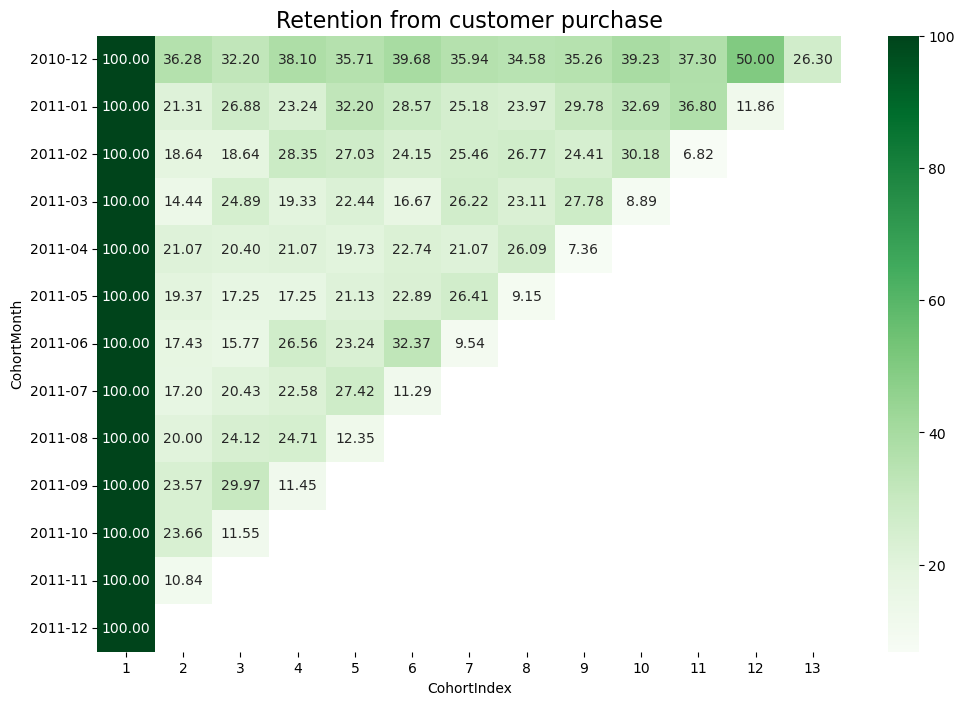

In [148]:
# Creat the heatmap to show the relationship
plt.figure(figsize=(12,8))

sns.heatmap(retention, annot=True, fmt='.2f', cmap='Greens')

plt.title('Retention from customer purchase', fontsize=16)
plt.show()

### Summary:
- Customers tend to churn rapidly within the first month after their initial purchase, with retention rates stabilizing in subsequent months. Additionally, specific months, such as the beginning and end of the year, show higher retention rates, indicating that more effort may be needed in these periods to maintain customer engagement.

# 5. RFM Analysis

## 5.1 Data Preparation

In [152]:
# Aggregate only customer id will lose some customers' purchase
agg_functions = {
    'quantity': 'sum',
    'invoice': 'nunique',  # calculate the number of unique invoices
    'total_order_value': 'sum',
    'invoice_date': ['min', 'max']  # Get the earliest and latest purchase times
}

In [153]:
# Aggregate the data
cleaned.groupby('customer_id').agg(agg_functions).reset_index().shape

(4321, 6)

In [154]:
# Find the losed customers' purchase in different countries
grouped = cleaned.groupby(['customer_id', 'country']).agg(agg_functions).reset_index()

In [155]:
# Rename columns
grouped.columns = ['customer_id', 'country', 'total_quantity', 'total_invoice', 'total_order_value', 'first_purchase', 'last_purchase']

In [156]:
# Check the result
grouped.head()

,customer_id,country,total_quantity,total_invoice,total_order_value,first_purchase,last_purchase
0,u12347,Iceland,2458,7,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00
1,u12348,Finland,2332,4,1437.24,2010-12-16 19:09:00,2011-09-25 13:13:00
2,u12349,Italy,630,1,1457.55,2011-11-21 09:51:00,2011-11-21 09:51:00
3,u1235,Norway,196,1,294.40,2011-02-02 16:01:00,2011-02-02 16:01:00
4,u12352,Norway,388,5,1125.28,2011-02-16 12:33:00,2011-11-03 14:37:00


In [157]:
# Check the number of records
len(grouped)

4328

## 5.2 Calculate RFM Metrics

In [159]:
# Aggregate the RFM values for all customers, without considering the country
rfm_combined = grouped.groupby('customer_id').agg({
    'last_purchase': lambda x: (pd.to_datetime('2012-01-01') - x.max()).days,  # recency
    'total_invoice': 'sum',  # frequency
    'total_order_value': 'sum'  # monetary
}).rename(columns={
    'last_purchase': 'Recency',
    'total_invoice': 'Frequency',
    'total_order_value': 'MonetaryValue'
}).reset_index()

In [160]:
# Check the result
rfm_combined.head()

,customer_id,Recency,Frequency,MonetaryValue
0,u12347,24,7,4310.00
1,u12348,97,4,1437.24
2,u12349,40,1,1457.55
3,u1235,332,1,294.40
4,u12352,58,5,1125.28


In [161]:
# Check the distribution
rfm_combined.describe()

,Recency,Frequency,MonetaryValue
count,4321.000000,4321.000000,4321.000000
mean,114.578338,4.203657,1900.787841
std,100.412547,7.512656,8211.285579
min,22.000000,1.000000,2.900000
25%,39.000000,1.000000,301.720000
50%,72.000000,2.000000,654.670000
75%,165.000000,5.000000,1608.100000
max,395.000000,202.000000,277460.420000


### Findings:
- These values represent the number of days since the last purchase, with a wide range from 22 days to 395 days. Generally, this is acceptable, indicating that some customers have purchased recently while others have not purchased for a long time.
- The purchase frequency ranges from 1 to 202, showing that some customers made only one purchase while others made many purchases. The large standard deviation indicates that the distribution of purchase frequency is uneven, with a few customers having particularly high purchase frequencies.
- The spending amount ranges from 2.9 to 277460.42, with a wide span. The mean and standard deviation suggest that a few customers have very high spending amounts, which raises the average.

## 5.3 Customer Segmentation - KMeans

In [164]:
# 5.3.1 Exploring the Data
# Get the RFM Values
df_rfm=rfm_combined[['Recency','Frequency','MonetaryValue']]

In [165]:
# Check the result
df_rfm.head()

,Recency,Frequency,MonetaryValue
0,24,7,4310.00
1,97,4,1437.24
2,40,1,1457.55
3,332,1,294.40
4,58,5,1125.28


In [166]:
# Check the distribution
df_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4321.000000,4321.000000,4321.000000
mean,114.578338,4.203657,1900.787841
std,100.412547,7.512656,8211.285579
min,22.000000,1.000000,2.900000
25%,39.000000,1.000000,301.720000
50%,72.000000,2.000000,654.670000
75%,165.000000,5.000000,1608.100000
max,395.000000,202.000000,277460.420000


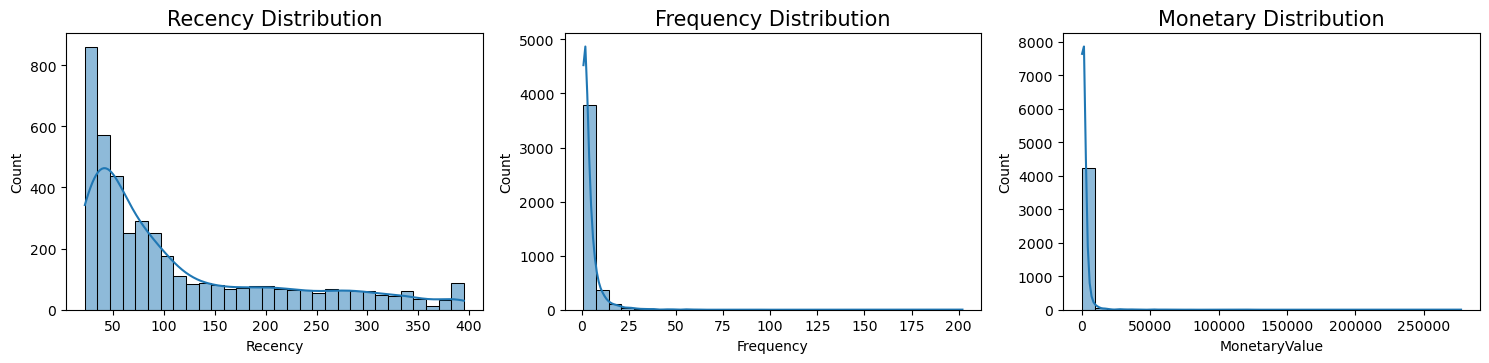

In [167]:
# Visualize the distribution of data
plt.figure(figsize=(15, 10))

# Plot the distribution of the 'Recency' variable
plt.subplot(3, 3, 1)
sns.histplot(df_rfm['Recency'], bins=30, kde=True)
plt.title('Recency Distribution',size=15)

# Plot the distribution of the 'Frequency' variable
plt.subplot(3, 3, 2)
sns.histplot(df_rfm['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution',size=15)

# Plot the distribution of the 'MonetaryValue' variable
plt.subplot(3, 3, 3)
sns.histplot(df_rfm['MonetaryValue'], bins=30, kde=True)
plt.title('Monetary Distribution',size=15)

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Display the plot
plt.show()

In [168]:
# Initialize a standard scaler
scaler=StandardScaler()

In [169]:
# Fit the scaler
scaler.fit(df_rfm)

StandardScaler()

In [170]:
# Scale and center the data
df_normalized=scaler.transform(df_rfm)

In [171]:
# 5.3.2 Choosing the Number of Clusters
# Set the maximum number of clusters to plot
max_clusters=10

In [172]:
# Initialize empty dictionary to store sum of squared errors
sse={}

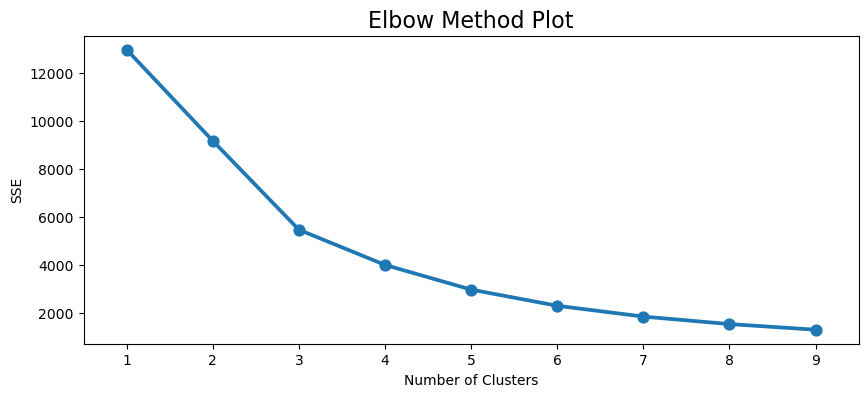

In [173]:
# Fit KMeans and calculate SSE for each k
for k in range(1,max_clusters):
    # Initialize KMeans with k clusters
    kmeans=KMeans(n_clusters=k,random_state=1)
    # Fit KMeans on the normalized dataset
    kmeans.fit(df_normalized)
    # Assing sum of squared distances to k element of dictionary
    sse[k]=kmeans.inertia_

# Initialize a figure of set size
plt.figure(figsize=(10,4))

# Creat an elbow plot of SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()),y=list(sse.values()))

# Add labels to the plot
plt.title('Elbow Method Plot',fontsize=16)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

# Display the plot
plt.show()

In [174]:
# 5.3.3 Clustering the data
# 5.3.3.1 Cluster with k=3
# Choose the first number of clusters
k=3

In [175]:
# Initialize KMeans
kmeans_k3=KMeans(n_clusters=k, random_state=1)

In [176]:
# Fit k-means clustering on the normalized data set
kmeans_k3.fit(df_normalized)

KMeans(n_clusters=3, random_state=1)

In [177]:
# Extract cluster labels
cluster_labels_k3=kmeans_k3.labels_

In [178]:
# Create a new DataFrame by adding a new cluster column to the cleaned data
df_clustered_k3=df_rfm.assign(Cluster=cluster_labels_k3)

In [179]:
# Group the data by cluster
grouped_k3=df_clustered_k3.groupby(['Cluster'])

In [180]:
# Calculate average RFM values and segment sizes per cluster value
grouped_k3.agg({'Recency':'mean','Frequency':'mean','MonetaryValue':['mean','count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          62.8       4.6        1809.0  3205
1          27.6      68.6       79006.2    24
2         268.4       1.6         475.4  1092

In [181]:
# 5.3.3.2 Cluster with k=4
# Choose another number of clusters 
k=4

In [182]:
# Initialize KMeans
kmeans=KMeans(n_clusters=k,random_state=1)

In [183]:
# Fit k-means clustering on the normalized data set
kmeans.fit(df_normalized)

KMeans(n_clusters=4, random_state=1)

In [184]:
# Extract cluster labels
cluster_labels=kmeans.labels_

In [185]:
# Create a new DataFrame by adding a new cluster column to the cleaned data
df_clustered=rfm_combined.assign(Cluster=cluster_labels)

In [186]:
# Check the result
df_clustered.head()

,customer_id,Recency,Frequency,MonetaryValue,Cluster
0,u12347,24,7,4310.00,1
1,u12348,97,4,1437.24,1
2,u12349,40,1,1457.55,1
3,u1235,332,1,294.40,0
4,u12352,58,5,1125.28,1


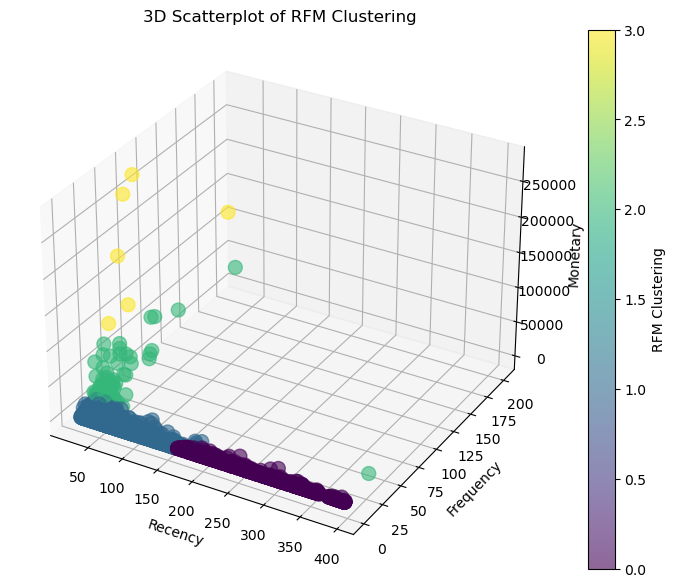

In [187]:
#visualization 3D scatterplot

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 3D-Scatterplot erstellen
scatter = ax.scatter(df_clustered['Recency'], df_clustered['Frequency'], df_clustered['MonetaryValue'],
                     c=df_clustered['Cluster'],cmap='viridis', s=100, alpha=0.6) 

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatterplot of RFM Clustering')

fig.colorbar(scatter, ax=ax, label='RFM Clustering')
plt.show()

In [188]:
# Group the data by cluster
grouped=df_clustered.groupby(['Cluster'])

In [189]:
# Calculate average RFM values and segment sizes per cluster value
cluster_summary=grouped.agg({'Recency':'mean','Frequency':'mean','MonetaryValue':['mean','count']}).round(1)

In [190]:
# Check the result
cluster_summary

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         269.1       1.5         471.8  1083
1          64.1       4.0        1477.6  3122
2          31.7      32.4       18232.3   110
3          29.2      73.7      180628.6     6

#### Comprehensive Analysis(Compare results)
- The clustering result with k=4 is likely more meaningful because it provides a more detailed segmentation of customer groups, including an additional top-value customer segment (Cluster 3). This is crucial for managing high-value customers. For practical business applications, such as developing precise marketing strategies and customer retention plans, k=4 offers more detailed and useful information.
- The clustering result with k=3, while simple and easy to understand, may not fully capture the diversity of customer segments.

In [192]:
# 5.3.4 Relative Importance
# Calculate average RFM values for each cluster
cluster_avg=df_clustered.groupby(['Cluster'])[['Recency','Frequency','MonetaryValue']].mean()

In [193]:
# Check the result
cluster_avg

,Recency,Frequency,MonetaryValue
Cluster,,,
0,269.124654,1.535549,471.767092
1,64.052210,4.002242,1477.595696
2,31.681818,32.400000,18232.320091
3,29.166667,73.666667,180628.588333


In [194]:
# Calculate average RFM values for the total customer population
population_avg=df_rfm.mean()

In [195]:
# Calculate relative importance of cluster's attribute value compared to population
# First, compute the ratio of the cluster's average value to the overall customer population average.
# Then subtract 1 to obtain the relative change (percentage change) compared to the overall customer population.
relative_imp=cluster_avg/population_avg-1

In [196]:
# Check the result
relative_imp

,Recency,Frequency,MonetaryValue
Cluster,,,
0,1.348827,-0.634711,-0.751804
1,-0.440975,-0.047914,-0.222640
2,-0.723492,6.707575,8.591981
3,-0.745443,16.524426,94.028274


#### Notation:
- This step calculates the variation of each cluster relative to the overall average. In other words, it assesses the increase or decrease in RFM values for each cluster compared to the overall average.
- Here, a relative importance greater than 0 indicates that the cluster's value for the respective metric is higher than the overall average，while less than 0 indicates it is lower than the overall average.

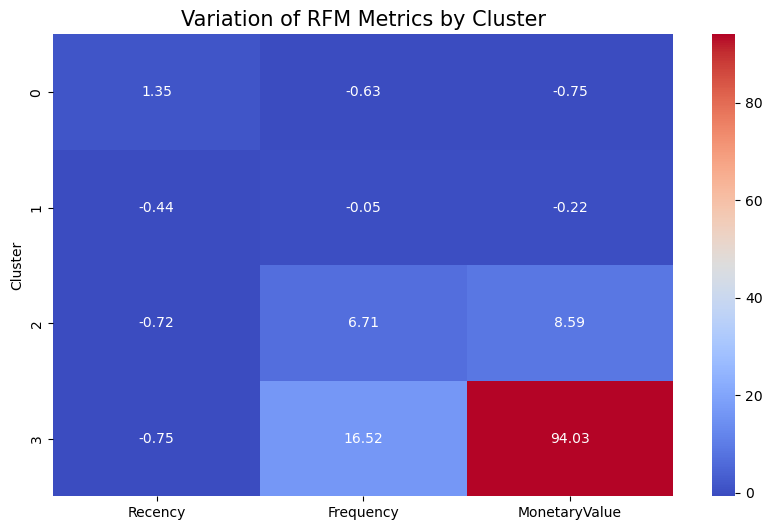

In [198]:
# Show the relative importance
# Change the figure size
plt.figure(figsize=(10,6))

# Plot the heatmap
sns.heatmap(data=relative_imp,annot=True,fmt='.2f',cmap='coolwarm')

# Add the plot title
plt.title('Variation of RFM Metrics by Cluster',fontsize=15)

plt.show()

#### Findings:
The heatmap reveals clear differences in performance across RFM metrics among the different clusters.
- The importance of the three attributes in Cluster 0 is relatively low, but Recency is somewhat more important.
- In Cluster 1, the importance of Frequency and MonetaryValue is very low.
- In Cluster 2, Frequency and MonetaryValue are very significant, with MonetaryValue being especially important.
- Cluster 3 is almost entirely driven by MonetaryValue, and Frequency is also important.


#### The clustering analysis identifies four customer segments:

- Cluster 0: Dormant Customers (low value)

- Cluster 1: Regular Customers (moderate value)

- Cluster 2: Loyal Customers (high value)

- Cluster 3: VIP Customers (top value)

In [201]:
# 5.3.4 Customers per cluster
# Check the clusters' summary
cluster_summary

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         269.1       1.5         471.8  1083
1          64.1       4.0        1477.6  3122
2          31.7      32.4       18232.3   110
3          29.2      73.7      180628.6     6

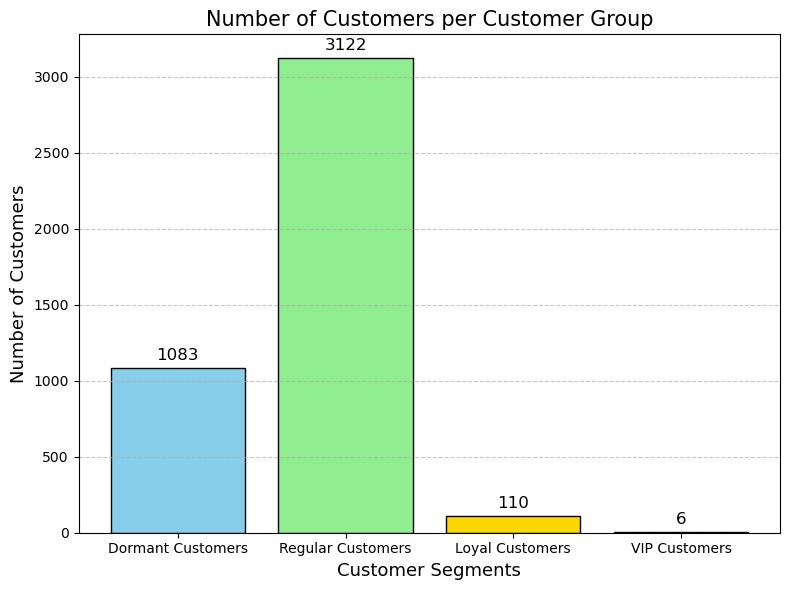

In [375]:
# Define the data
clusters = ['Dormant Customers', 'Regular Customers', 'Loyal Customers', 'VIP Customers']
counts = [1083, 3122, 110, 6]  # Values from the cluster_summary's MonetaryValue(count)
colors = ['skyblue', 'lightgreen', 'gold', 'red']

# Create bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(clusters, counts, color=colors, edgecolor='black')

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height() # Get the height of the current bar (i.e., the value of the bar)
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval),ha='center', fontsize=12) # Add text labels above each bar to show the bar's value 

# Add bar chart title and labels with enhanced styling
plt.title('Number of Customers per Customer Group', fontsize=15)
plt.xlabel('Customer Segments', fontsize=13)
plt.ylabel('Number of Customers', fontsize=13)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

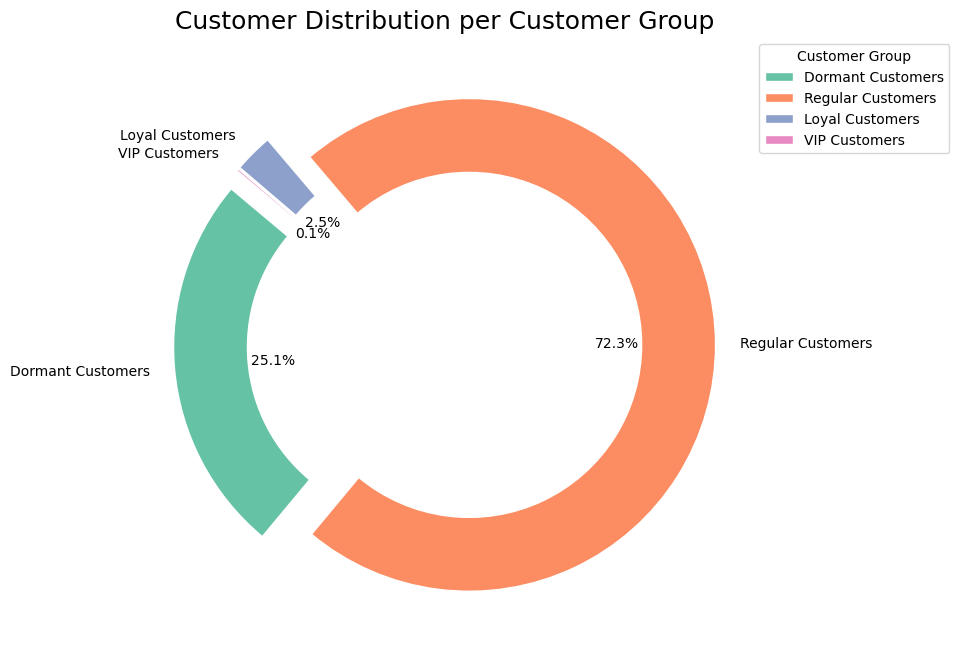

In [379]:
# Show the clusters' proportion
# Create pie plot with enhancements
plt.figure(figsize=(10, 8))

# Define explode parameter to highlight the largest slice
explode = [0.1] * len(counts)  # Adjust the size of the explosion for each slice

# Define a color palette
colors = plt.get_cmap('Set2').colors 

# Create pie chart
plt.pie(counts, 
        labels=clusters, 
        autopct='%1.1f%%', 
        colors=colors, 
        startangle=140, 
        explode=explode,  # Highlight each slice
        wedgeprops=dict(width=0.3, edgecolor='w')  # Make the pie chart a donut chart for a cleaner look
       )

# Add pie chart title with enhanced styling
plt.title('Customer Distribution per Customer Group', fontsize=18)

# Add a legend to the pie chart
plt.legend(clusters, title='Customer Group', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


## Findings:
- The majority of customers are classified as Regular Customers, accounting for 72.3% of the total, indicating that this group dominates the overall customer base.
- Dormant Customers make up 25.1%, showing that although they participate in purchases less frequently, they still represent an important segment.
- Loyal Customers and VIP Customers represent a very small percentage, at 2.5% and 0.1% respectively, reflecting their limited numbers but potentially higher purchase frequency or value.
- Overall, the segmentation results indicate that Regular Customers form the primary customer group, while VIP Customers are extremely rare but possibly more valuable.

# 5.4 Develop Marketing Strategies 

### 5.4.1 Cluster 0: Low Value, Dormant Customers

#### 5.4.1.1 Characteristics
- Recency: 269.1 (long time since last purchase)
- Frequency: 1.5 (low purchase frequency)
- Monetary Value: 471.8 (low spending amount)
- Customer Count: 1083

#### 5.4.1.2 Marketing Strategies
- Reactivation Campaigns: Use special discounts, coupons, or limited-time promotions to attract these customers back. Send reminders via email or SMS to increase engagement.
- Increase Purchase Frequency: Implement incentive mechanisms, such as "buy one get one free" or "discounts on minimum purchase," to encourage customers to buy more frequently.
- Improve Customer Experience: Analyze reasons for customer churn, optimize product and service experiences, and enhance purchase motivation.
- Establish Communication Channels: Maintain contact through regular email marketing or social media interactions to understand customer needs and feedback, and increase engagement.

### 5.4.2 Cluster 1: Moderate Value, Regular Customers

#### 5.4.2.1 Characteristics: 
- Recency: 64.1 (short time since last purchase)
- Frequency: 4.0 (moderate purchase frequency)
- Monetary Value: 1477.6 (moderate spending amount)
- Customer Count: 3122

#### 5.4.2.2 Marketing Strategies:
- Loyalty Programs: Design loyalty programs such as point systems, membership discounts, and special offers to encourage continued purchases.
- Personalized Recommendations: Use purchase history to recommend related products, increasing interest in buying.
- Regular Promotions: Conduct regular promotional activities to attract customers to buy more products, thereby increasing purchase frequency.
- Customer Interaction: Increase customer engagement and satisfaction through regular surveys or interactive activities.

### 5.4.3 Cluster 2: High Value, Loyal Customers

#### 5.4.3.1 Characteristics: 
- Recency: 31.7 (short time since last purchase)
- Frequency: 32.4 (high purchase frequency)
- Monetary Value: 18232.3 (high spending amount)
- Customer Count: 110

#### 5.4.3.2 Marketing Strategies:
- Personalized Services: Provide personalized services and exclusive offers to maintain their loyalty.
- Premium Membership Programs: Design premium membership plans offering exclusive benefits and tailored services.
- Exclusive Events: Invite these customers to VIP events, product launches, or limited-time sales to enhance engagement.
- Feedback Collection: Regularly collect feedback to understand their needs and expectations, and improve products and services.

### 5.4.4 Cluster 3: Top Value, VIP Customers

#### 5.4.4.1 Characteristics: 
- Recency: 29.2 (very short time since last purchase)
- Frequency: 73.7 (very high purchase frequency)
- Monetary Value: 180628.6 (top spending amount)
- Customer Count: 6

#### 5.4.4.2 Marketing Strategies:
- High-End Services: Offer the highest level of service and personalized experiences, such as exclusive customer managers and luxury experiences.
- Custom Offers: Provide tailored offers and rewards to enhance their loyalty.
- Exclusive Events: Invite them to highly exclusive events, such as private shopping sessions or preview events for special products.
- Long-Term Relationship Maintenance: Build long-term relationships through high-end customer care programs to maintain their loyalty to the brand.

### 5.4.5 Additional Recommendations

- Continuous Monitoring: Regularly track and evaluate the effectiveness of marketing strategies using metrics such as conversion rates, customer retention rates, and overall sales performance.
- Cross-Cluster Strategies: Consider implementing strategies that benefit multiple segments. For example, using feedback from Cluster 1 to improve the overall customer experience can positively impact all clusters.
- Personalization Across Channels: Ensure that personalization strategies are applied consistently across all marketing channels (email, social media, website) to create a cohesive customer experience.
- Long-Term Customer Value: Focus on strategies that not only address current needs but also aim to increase the long-term value of customers by nurturing their relationship with the brand.

By incorporating these suggestions, you can enhance the effectiveness of your marketing strategies and better address the diverse needs of each customer segment.






